[MIT License](https://github.com/cdslaborg/paramonte#license)  
[ParaMonte: plain powerful parallel Monte Carlo library](https://github.com/cdslaborg/paramonte).  
Copyright (C) 2012-present, [The Computational Data Science Lab](https://www.cdslab.org/#about)  
https://github.com/cdslaborg/paramonte  

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Sampling a 4-dimensional MultiVariate Normal distribution (MVN) via the ParaMonte library's ParaDRAM routine    

**The logic of Monte Carlo sampling** is very simple:

Suppose we have a mathematical objective function defined on a `ndim`-dimensional domain. Typically, this domain is defined on the space of real numbers. In general, understanding and visualizing the structure of such objective functions is an extremely difficult task, if not impossible. As a better alternative, you employ Monte Carlo techniques that can randomly explore the structure of the objective function and find the function's extrema.  

In the following example below, an example of one of the simplest such objective functions, the **Multivariate Normal Distribution (MVN)**, is constructed and sampled using the ParaMonte library samplers, here, the **ParaDRAM** sampler (**Delayed-Rejection Adaptive Metropolis-Hastings Markov Chain Monte Carlo sampler**).  

Suppose we want to sample random points from a [MultiVariate Normal (MVN) Probability Density Function (PDF)](https://en.wikipedia.org/wiki/Multivariate_normal_distribution). The PDF equation of MVN is the following,  

$$
\large
\pi (x, \mu, \Sigma, k = 4) = (2\pi)^{-\frac{k}{2}} ~ |\Sigma|^{-\frac{1}{2}} ~ 
\exp
\bigg( 
-\frac{1}{2} (x-\mu)^T ~ \Sigma^{-1} ~ (x-\mu)
\bigg)
$$

The following Python function `getLogFunc()` returns the natural logarithm of the Probability Density Function of the multivariate Normal distribution.  

---  

> Since the mathematical objective functions (e.g., probability density functions) can take extremely small or large values, we often work with their natural logarithms instead. **This is the reason behind the naming convention used in the ParaMonte library for** the user's objective functions: **getLogFunc**, implying that **the user must provide a function that returns the natural logarithm of the target objective function**.  
  
  
See [this Jupyter Notebook](https://nbviewer.jupyter.org/github/cdslaborg/paramontex/blob/master/Python/Jupyter/working_with_logarithm_of_objective_function.ipynb) for an in-depth discussion of why we need to work with the logarithm of mathematical objective functions in optimization and sampling problems.  

---  

In [2]:
# activate interactive plotting in Jupyter environment
%matplotlib notebook

In [3]:
import numpy as np

NDIM = 4                                # number of dimensions of the domain of the MVN PDF
MEAN =  np.double([-10, 15., 20., 0.0]) # This is the mean of the MVN PDF.
COVMAT = np.double( [ [1.0,.45,-.3,0.0] # This is the covariance matrix of the MVN PDF.
                    , [.45,1.0,0.3,-.2]
                    , [-.3,0.3,1.0,0.6]
                    , [0.0,-.2,0.6,1.0]
                    ] )

INVCOV = np.linalg.inv(COVMAT) # This is the inverse of the covariance matrix of the MVN distribution.

# The following is the log of the coefficient used in the definition of the MVN.

MVN_COEF = NDIM * np.log( 1. / np.sqrt(2.*np.pi) ) + np.log( np.sqrt(np.linalg.det(INVCOV)) )

# the logarithm of objective function: log(MVN)

def getLogFunc(point):
    """
    Return the logarithm of the MVN PDF.
    """
    normedPoint = MEAN - point
    return MVN_COEF - 0.5 * ( np.dot(normedPoint,np.matmul(INVCOV,normedPoint)) )

We will sample random points from the objective function by calling the **ParaDRAM** sampler (**Delayed-Rejection Adaptive Metropolis-Hastings Markov Chain Monte Carlo sampler**) of the ParaMonte library.  

## Running a ParaDRAM simulation on a single processor

>**To run the sampler in parallel**, you will have to first save the MPI-enabled script as an external file. Visit the [ParaMonte library's documentation website](http://cdslab.org/paramonte/notes/run/python/) for more information, or see [this parallel ParaDRAM simulation Jupyter notebook example](https://nbviewer.jupyter.org/github/cdslaborg/paramontex/blob/master/Python/Jupyter/sampling_multivariate_normal_density_function_via_paradram_parallel.ipynb).  

In [4]:
import paramonte as pm

First we will check what version of the ParaMonte library your are using,

In [5]:
print( pm.version.kernel.get() )
print( pm.version.interface.get() )

ParaMonte Python Kernel Version 1.2.0
ParaMonte Python Interface Version 2.0.6


We can also **dump** the ParaMonte library interface version,

In [6]:
print( pm.version.kernel.dump() )
print( pm.version.interface.dump() )

1.2.0
2.0.6


We can also verify the existence of the essential components of the current installation of the ParaMonte Python library on the system,

In [7]:
pm.verify()


:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
::::                                                                                       ::::

       _/_/_/_/                                   _/_/    _/_/
        _/    _/                                  _/_/_/_/_/                     _/
       _/    _/ _/_/_/_/   _/ /_/_/ _/_/_/_/     _/  _/  _/   _/_/   _/_/_/   _/_/_/  _/_/_/
      _/_/_/   _/    _/   _/_/     _/    _/     _/      _/  _/   _/ _/    _/   _/   _/_/_/_/                        
     _/       _/    _/   _/       _/    _/     _/      _/  _/   _/ _/    _/   _/   _/    
  _/_/_/       _/_/_/_/ _/         _/_/_/_/ _/_/_/  _/_/_/  _/_/  _/    _/   _/_/   _/_/_/


                                          ParaMonte
                                   plain powerful parallel
                                     Monte Carlo library
                                        Version 2.0.6

::::                                       

---  
### Setting up the ParaDRAM simulation specifications

Now, define a ParaDRAM sampler instance,  

In [8]:
pmpd = pm.ParaDRAM()

The **simplest scenario** is to **run the simulation with the default specifications** that are appropriately determined by the ParaDRAM sampler. However, for the purpose of clarity reproducibility, we will specify a few simulation specs,

> For a complete list of all ParaDRAM simulation specifications, visit the [ParaDRAM simulation specifications webpage](https://www.cdslab.org/paramonte/notes/usage/paradram/specifications/).  

### The simulation output file names and storage path   
We will store all output files in a directory with the same name as this Jupyter Notebook's name and with the same prefix.  

> By default, all ParaDRAM simulation output files are named properly (see [this page](https://www.cdslab.org/paramonte/notes/usage/paradram/output/) for a review of ParaDRAM simulation output files). **In general, it is a good habit to specify an output file prefix for any ParaDRAM simulation**. This way, the restart of an incomplete simulation, if it happens for some reasons, would be seamless and doable by just rerunning the simulation, without any change of any sort to any parts of the codes or the simulation.  

In [9]:
pmpd.spec.outputFileName = "./sampling_multivariate_normal_density_function_via_paradram/mvn_serial"

### Ensuring the reproducibility of the results  
We will also initialize the random seed to a fixed number to ensure the reproducibility of the simulation results in the future,  

In [10]:
pmpd.spec.randomSeed = 3751

Not so important, but we will also specify a chainSize here, 30000, the number of **unique points** to be sampled from the objective function. This number is much smaller than the default 100,000 unique sample points of the sampler.  

In [11]:
pmpd.spec.chainSize = 30000

For the sake of illustration, we will also request an ASCII-format restart output file,  

In [12]:
pmpd.spec.restartFileFormat = "ascii"

### Calling the ParaDRAM sampler  
Note that none of the above specification settings are necessary, but is in general a good habit to define them prior to the simulation.  
We now call the ParaDRAM sampler routine to run the sampling simulation,  

In [13]:
# run the ParaDRAM sampler
pmpd.runSampler ( ndim = 4
                , getLogFunc = getLogFunc
                )


ParaDRAM - NOTE: Running the ParaDRAM sampler in serial mode...
ParaDRAM - NOTE: To run the ParaDRAM sampler in parallel mode visit:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     https://www.cdslab.org/paramonte
ParaDRAM - NOTE: 
ParaDRAM - NOTE: If you are using Jupyter notebook, check the Jupyter's 
ParaDRAM - NOTE: terminal window for realtime simulation progress and report.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readReport()      # to read the summary report from the output report file.
ParaDRAM - NOTE:     pmpd.readSample()      # to read the final i.i.d. sample from the output sample file.
ParaDRAM - NOTE:     pmpd.readChain()       # to read the uniquely-accepted points from the output chain file.
ParaDRAM - NOTE:     pmpd.readMarkovChain() # to read the Markov Chain. NOT recommended for very large chains.
ParaDRAM - NOTE:     pmpd.readRestart()     # to read the contents of an ASCII-format output restart file.
ParaDRAM 

This will print the realtime simulation progress information on your **Anaconda prompt window** (not inside your Jupyter notebook). Once the simulation is finished, the ParaDRAM routine generates 5 output files, each of which contains information about certain aspects of the simulation,  

-   [mvn_serial_process_1_report.txt](sampling_multivariate_normal_density_function_via_paradram/mvn_serial_process_1_report.txt)  
    This file contains reports about all aspects of the simulation, from the very beginning of the simulation to the very last step, including the postprocessing of the results and final sample refinement.  

-   [mvn_serial_process_1_progress.txt](sampling_multivariate_normal_density_function_via_paradram/mvn_serial_process_1_progress.txt)  
    This file contains dynamic realtime information about the simulation progress. The frequency of the progress report to this file depends on the value of the simulation specification `progressReportPeriod`.  

-   [mvn_serial_process_1_sample.txt](sampling_multivariate_normal_density_function_via_paradram/mvn_serial_process_1_sample.txt)  
    This file contains the final fully-refined decorrelated i.i.d. random sample from the objective function.  

-   [mvn_serial_process_1_chain.txt](sampling_multivariate_normal_density_function_via_paradram/mvn_serial_process_1_chain.txt)  
    This file contains the Markov chain, generally in either binary or condensed (compact) ASCII format to improve the storage efficiency of the chain on your computer.  



Now, we can read the generated output sample, contained in the file suffixed with `*_sample.txt`.

In [14]:
pmpd.readSample() # generates pmpd.sampleList
sample = pmpd.sampleList[0]


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readSample()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the sample file(s) to be parsed.


ParaDRAM - NOTE: 1 files detected matching the pattern: "./sampling_multivariate_normal_density_function_via_paradram/mvn_serial*_sample.txt"


ParaDRAM - NOTE: processing sample file: D:\Dropbox\Projects\20180101_ParaMonte\paramontex\Python\Jupyter\sampling_multivariate_normal_density_function_via_paradram\mvn_serial_process_1_sample.txt
ParaDRAM - NOTE: reading the file contents... done in 0.015278 seconds.
ParaDRAM - NOTE: ndim = 4, count = 7504
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample correlation matrix... 
ParaDRAM

By default, the sampler generates a highly refined decorrelated final sample. Essentially, **the ParaDRAM sampler refining the Markov chain for as long as there is any residual auto-correlation in any of the individual variables of the Markov chain that has been sampled**. This is an extremely strong and conservative refinement strategy (and it is done so in the ParaDRAM algorithm for a good reason: to **ensure independent and identically distributed (i.i.d.) samples from the objective function**.  

This extreme refinement can be relaxed and controlled by the user, by setting the following ParaDRAM simulation specification variable prior to the simulation run,

In [15]:
pmpd.spec.sampleRefinementCount = 1

If you rerun the simulation with this specification set and, you will notice about a **three-fold** increase in the final sample size. Note that the above specification has to be set **before** running the simulation in the above if you really want to use it (also, do not forget to specify a new output file prefix for the new simulation because simulations cannot be overwritten). A value of `1` will cause the ParaDRAM sampler to refine the Markov chain for only one round, which what most people in the MCMC community do.

To quickly visualize the generated sample as a histogram, try,

ParaDRAM - NOTE: making the histplot plot... 

<IPython.core.display.Javascript object>


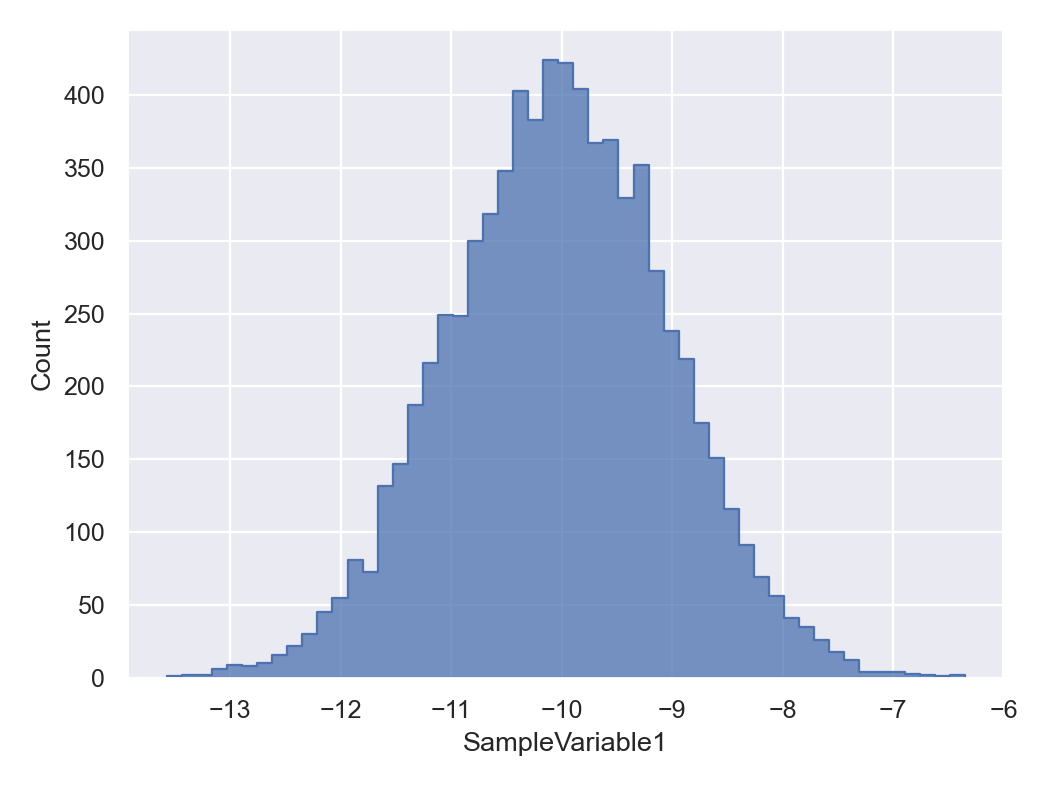

done in 0.194901 seconds.


In [16]:
sample.plot.histplot()

How about adding a target value to this histogram plot? By default, if no `value` is specified for the target object, it will add the state corresponding to the mode of objective funciton to the plot, as inferred from the sample file,  

ParaDRAM - NOTE: making the histplot plot... 

<IPython.core.display.Javascript object>


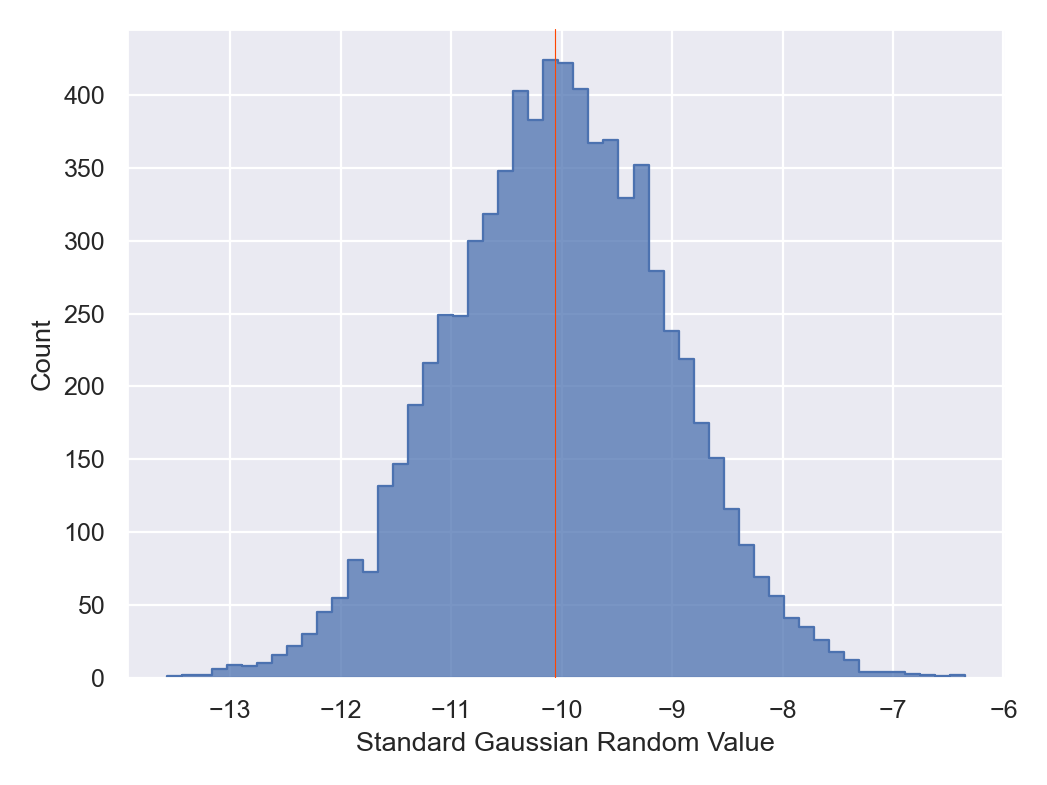

done in 0.119891 seconds.


In [17]:
sample.plot.histplot.reset()
sample.plot.histplot()
sample.plot.histplot.currentFig.axes.set_xlabel("Standard Gaussian Random Value")
sample.plot.histplot.target() # add a line corresponding to the maxLogFunc (mode) of the sampled points.

However, assiging other values is also possible. For example, let's say that we want to add the mean and 1-sigma limits to the plot, instead of the single mode,  

ParaDRAM - NOTE: making the histplot plot... 

<IPython.core.display.Javascript object>


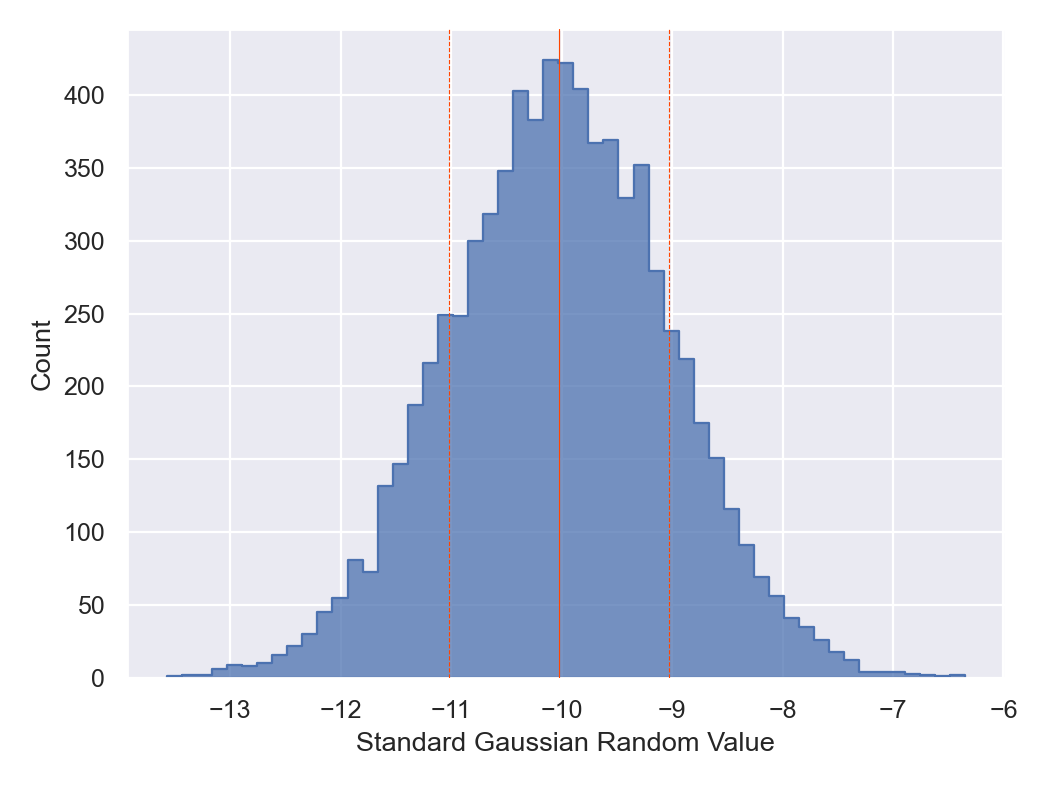

done in 0.109891 seconds.


In [18]:
sample.plot.histplot()
sample.plot.histplot.currentFig.axes.set_xlabel("Standard Gaussian Random Value")

avg = sample.df.SampleVariable1.mean()
sample.plot.histplot.target( value = avg )

std = sample.df.SampleVariable1.std()
sample.plot.histplot.target.axvline.kws.linestyle = "--"
sample.plot.histplot.target( value = avg - std )
sample.plot.histplot.target( value = avg + std )

We can also plot all of the variables at the same time in a single figure,

In [19]:
sample.df.head()

SampleLogFunc  SampleVariable1  SampleVariable2  SampleVariable3  \
0      -7.278832       -10.609075        14.000948        21.591041   
1      -7.278832       -10.609075        14.000948        21.591041   
2      -4.725460       -11.363133        13.571979        21.002667   
3      -4.725460       -11.363133        13.571979        21.002667   
4      -4.725460       -11.363133        13.571979        21.002667   

   SampleVariable4  
0         1.234182  
1         1.234182  
2         1.223883  
3         1.223883  
4         1.223883

ParaDRAM - NOTE: making the histplot plot... 

<IPython.core.display.Javascript object>


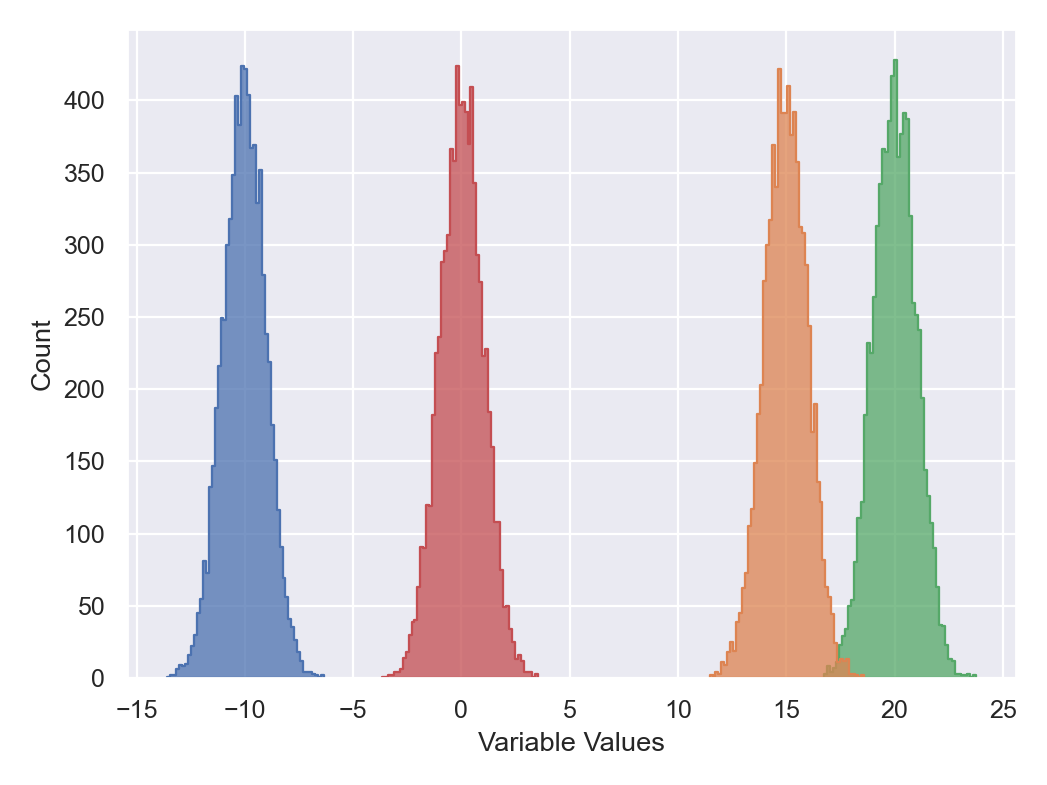

done in 0.164925 seconds.


In [20]:
sample.plot.histplot( xcolumns = [1,2,3,4] )

Perhaps, we would also want to add legend and change the x-axis title,

ParaDRAM - NOTE: creating a histplot plot object from scratch... done in 0.0 seconds.
ParaDRAM - NOTE: making the histplot plot... 

<IPython.core.display.Javascript object>


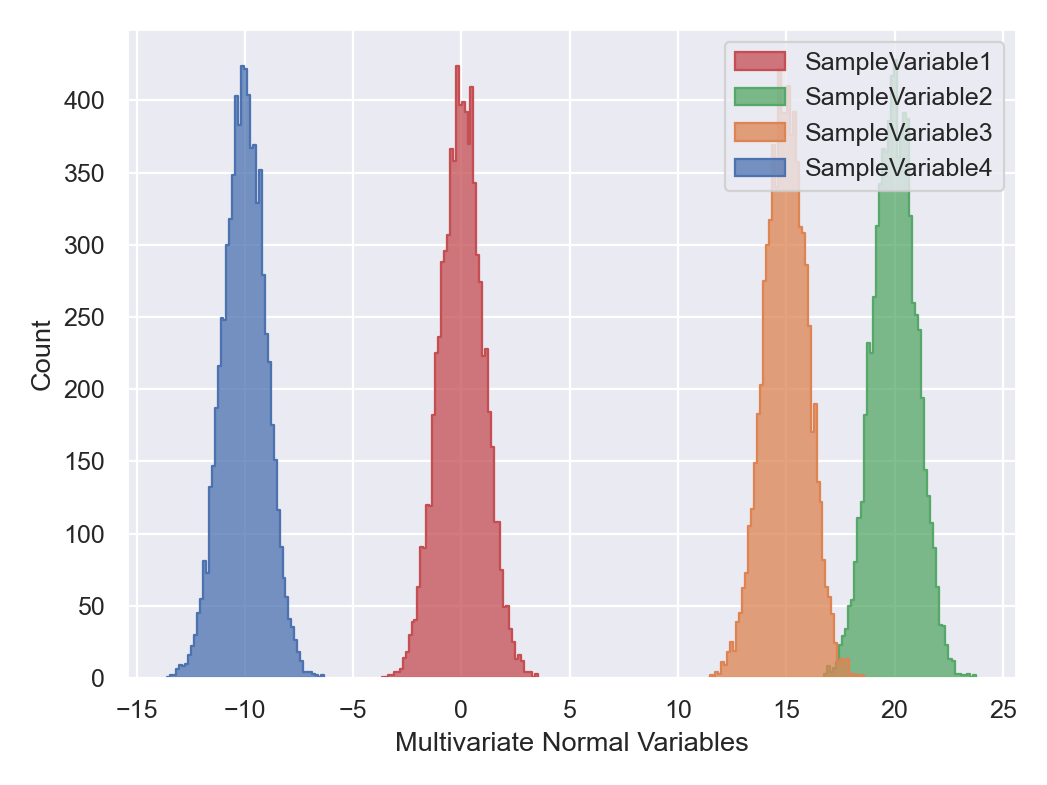

done in 0.169874 seconds.


Text(0.5, 31.07499999999998, 'Multivariate Normal Variables')

In [21]:
sample.plot.histplot.reset("hard") # reseting to the default is not necessary, but does not hurt either.
sample.plot.histplot.legend.enabled = True
sample.plot.histplot( xcolumns = [1,2,3,4] )
sample.plot.histplot.currentFig.axes.set_xlabel("Multivariate Normal Variables")

To make a trace-plot of the sample, try,  

ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


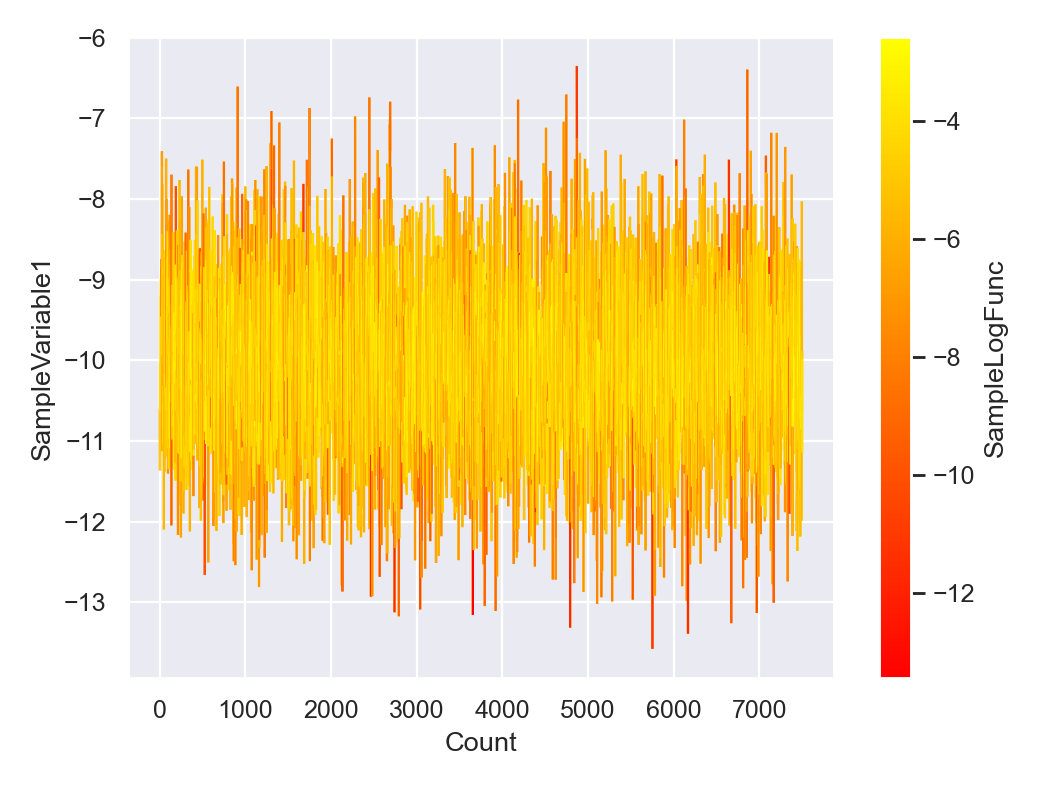

done in 0.179971 seconds.


In [22]:
sample.plot.line()

To change the scale of the x-axis, try,  

ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


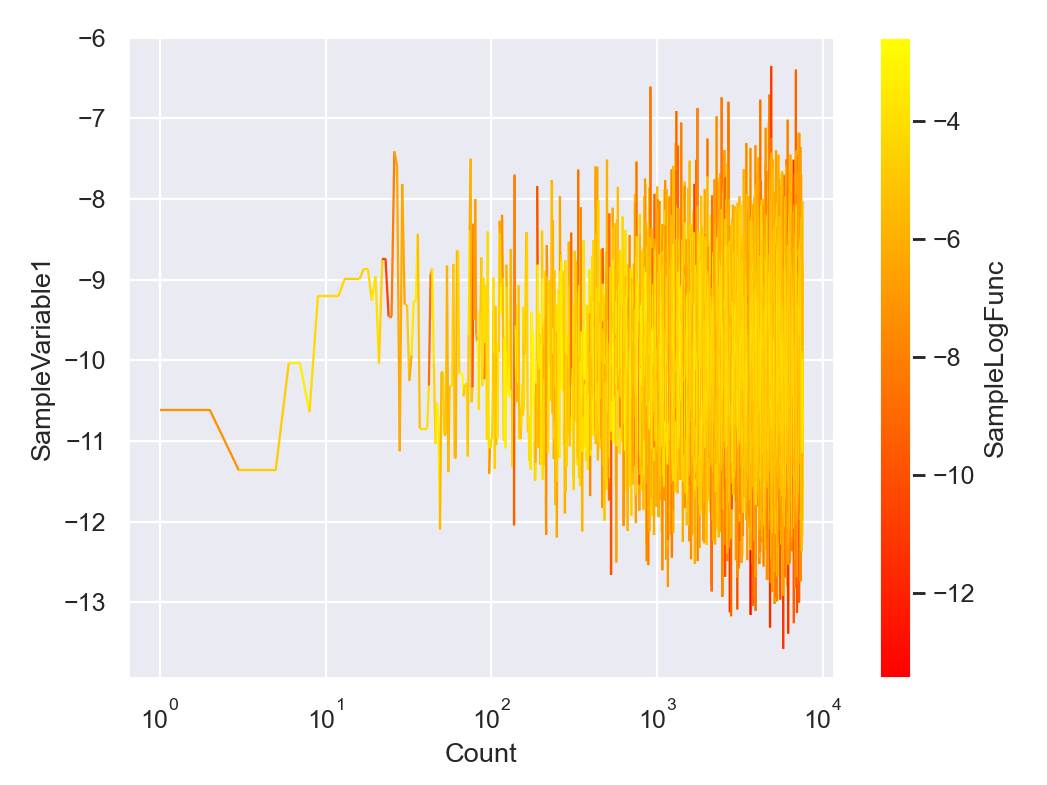

done in 0.215182 seconds.


In [23]:
sample.plot.line()
sample.plot.line.currentFig.axes.set_xscale("log")

By default, the color of the line in the trace-plot will represent the value returned by `getLogFunc()` at the given sampled point.

In [24]:
sample.plot.line.ccolumns

'SampleLogFunc'

To turn the color off, we can instead try,

ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


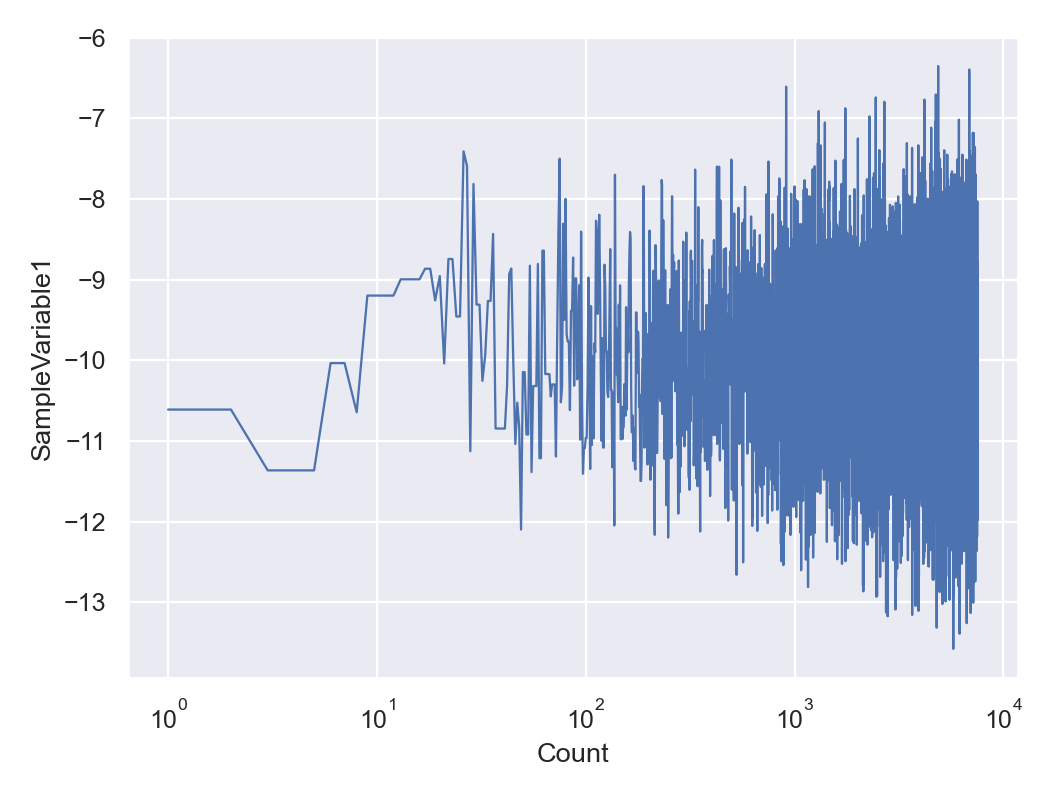

done in 0.090154 seconds.


In [25]:
sample.plot.line.ccolumns = None
sample.plot.line()
sample.plot.line.currentFig.axes.set_xscale("log")

There are many other properties of the plot that can be set or modified via the attributes of the `pmpd.sampleList[0].plot.line` object. To see them all, **uncomment** the following line to see the documentation of the object,  

In [27]:
# sample.plot.line.helpme()

We could also plot all variables in the sample plot, 

ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


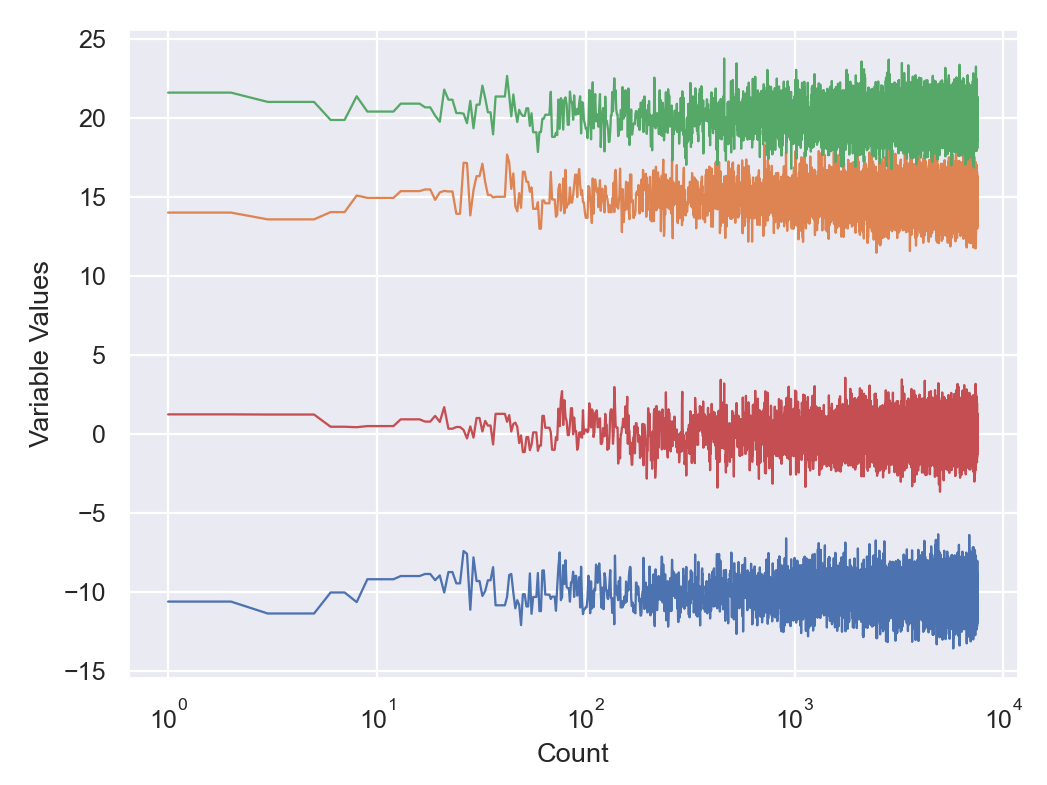

done in 0.094789 seconds.


In [28]:
sample.plot.line.reset()         # reset to the default settings
sample.plot.line.ccolumns = None # turn off the color-mapping
sample.plot.line.ycolumns = pmpd.sampleList[0].df.columns[1:] # exclude the SampleLogFunc column
sample.plot.line()
sample.plot.line.currentFig.axes.set_xscale("log")

We could also make scatter or line-scatter trace-plots of the sampled points. The ParaMonte library has a visualization tool for that purpose with some nice predefined settings that can be changed by the user. For example, let's make a scatter and line-scatter traceplots of the first sampled variable,

ParaDRAM - NOTE: making the scatter plot... 

<IPython.core.display.Javascript object>


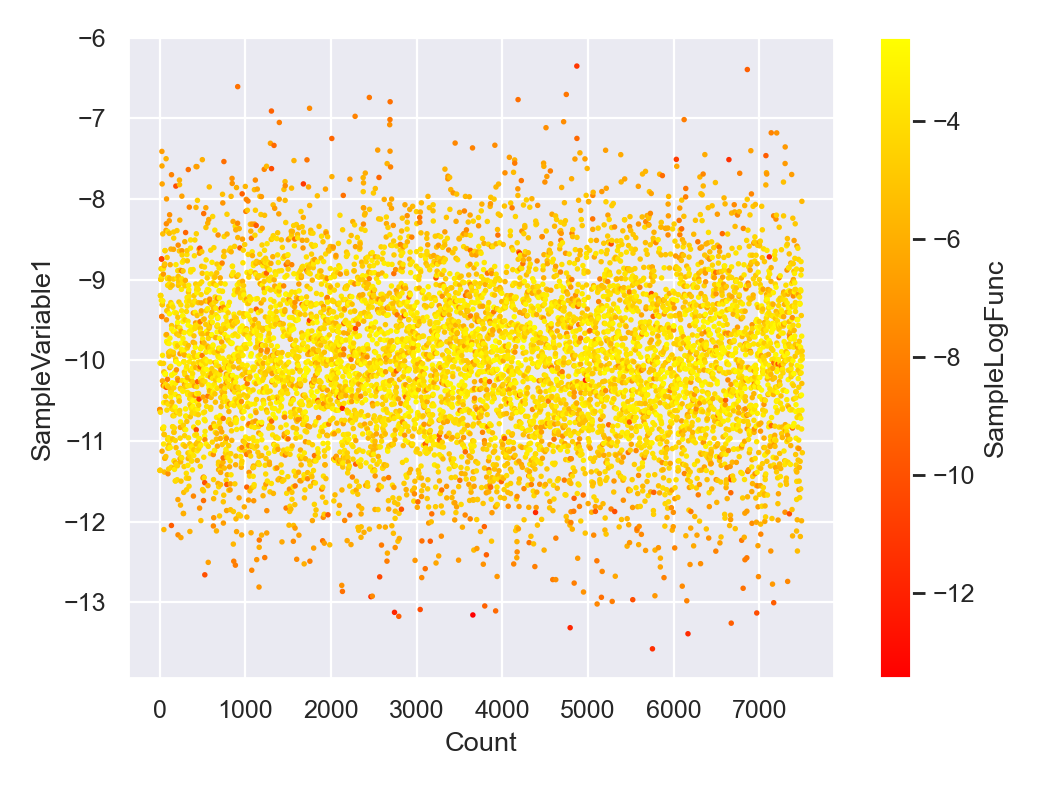

done in 0.122024 seconds.


In [29]:
sample.plot.scatter()

ParaDRAM - NOTE: making the lineScatter plot... 

<IPython.core.display.Javascript object>


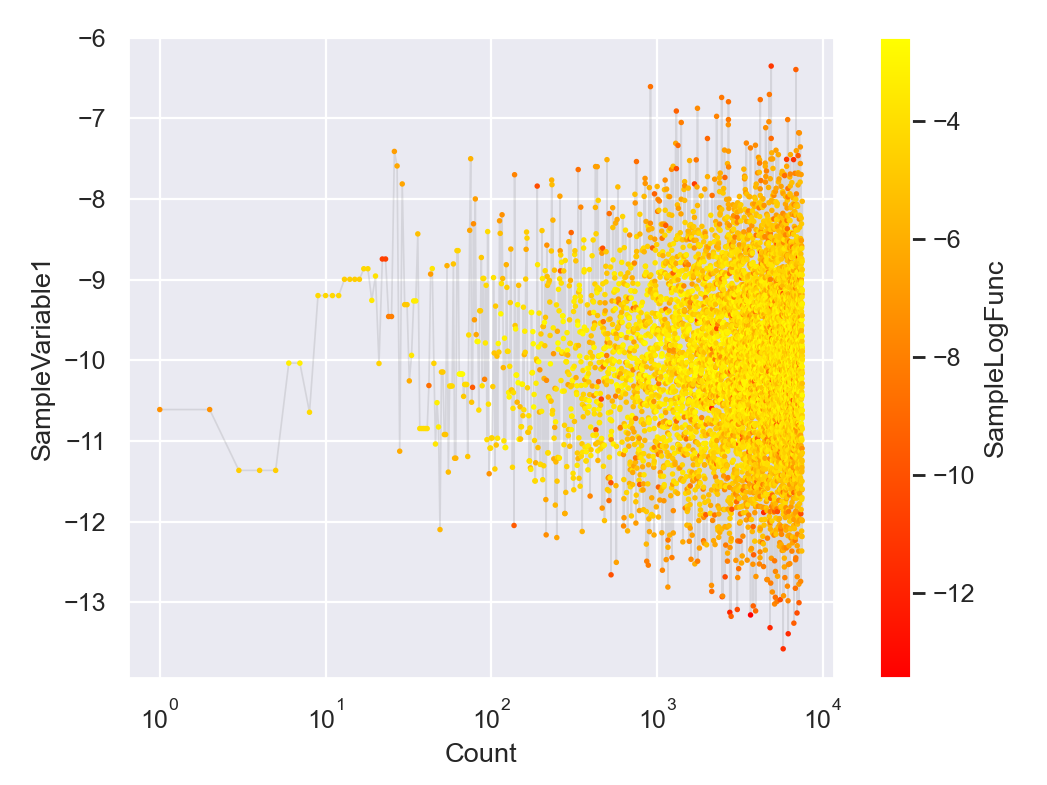

done in 0.127446 seconds.


In [31]:
sample.plot.lineScatter()
sample.plot.lineScatter.currentFig.axes.set_xscale("log")

Setting or modifying the properties of a scatter or lineScatter plot is identical to the line plot. By default, the sampler makes a scatter plot of only the first sampled variable as a function of the order by which the points appear in the sample file. Alternatively, we may want to plot individual variables against each other. For example, to make scatter plots of all variables against the `logFunc`, 

ParaDRAM - NOTE: making the scatter plot... 

<IPython.core.display.Javascript object>


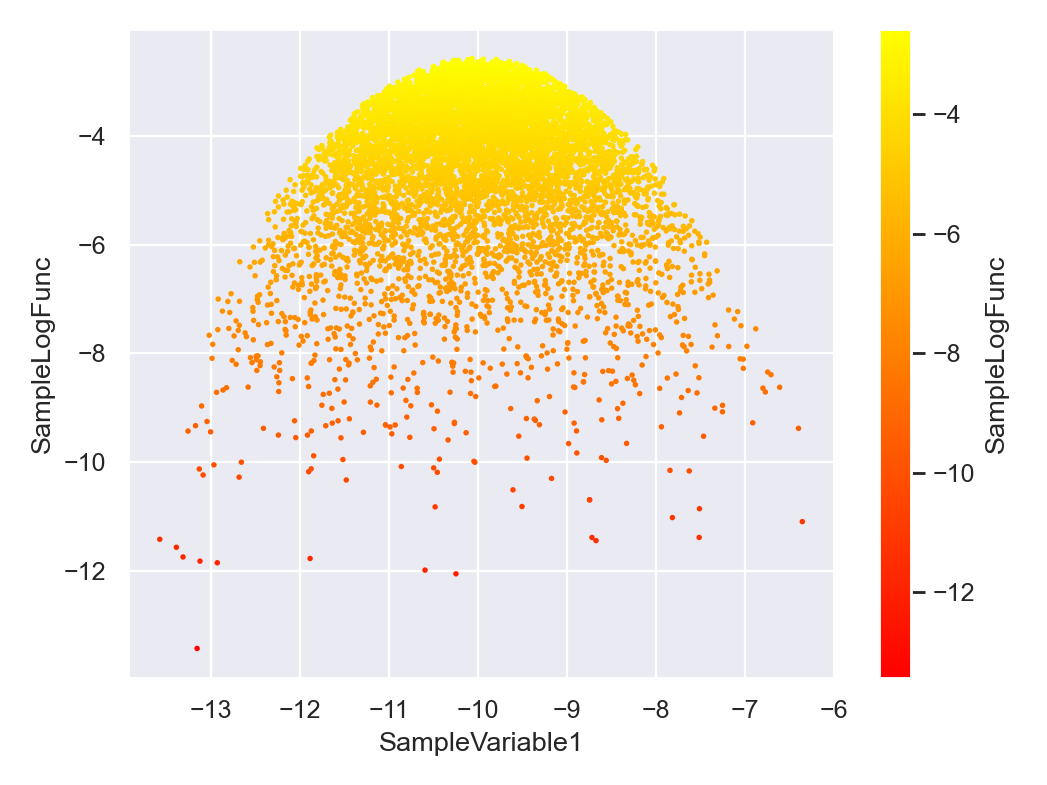

done in 0.119694 seconds.
ParaDRAM - NOTE: making the scatter plot... 

<IPython.core.display.Javascript object>


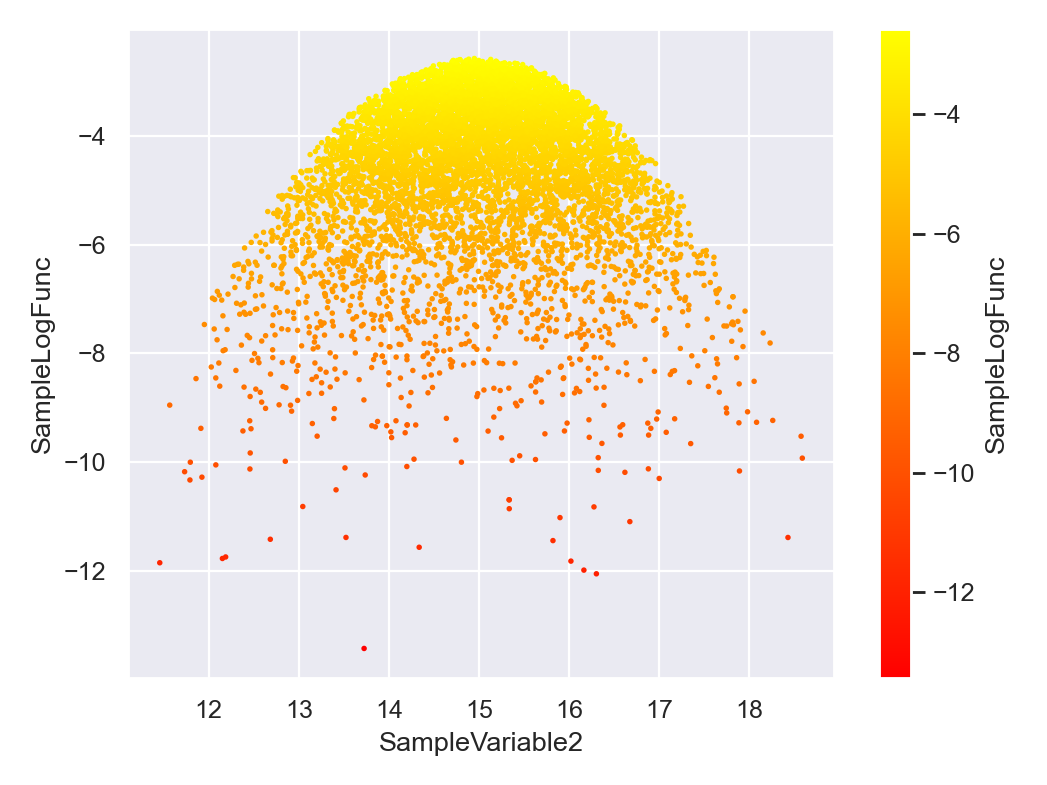

done in 0.109524 seconds.
ParaDRAM - NOTE: making the scatter plot... 

<IPython.core.display.Javascript object>


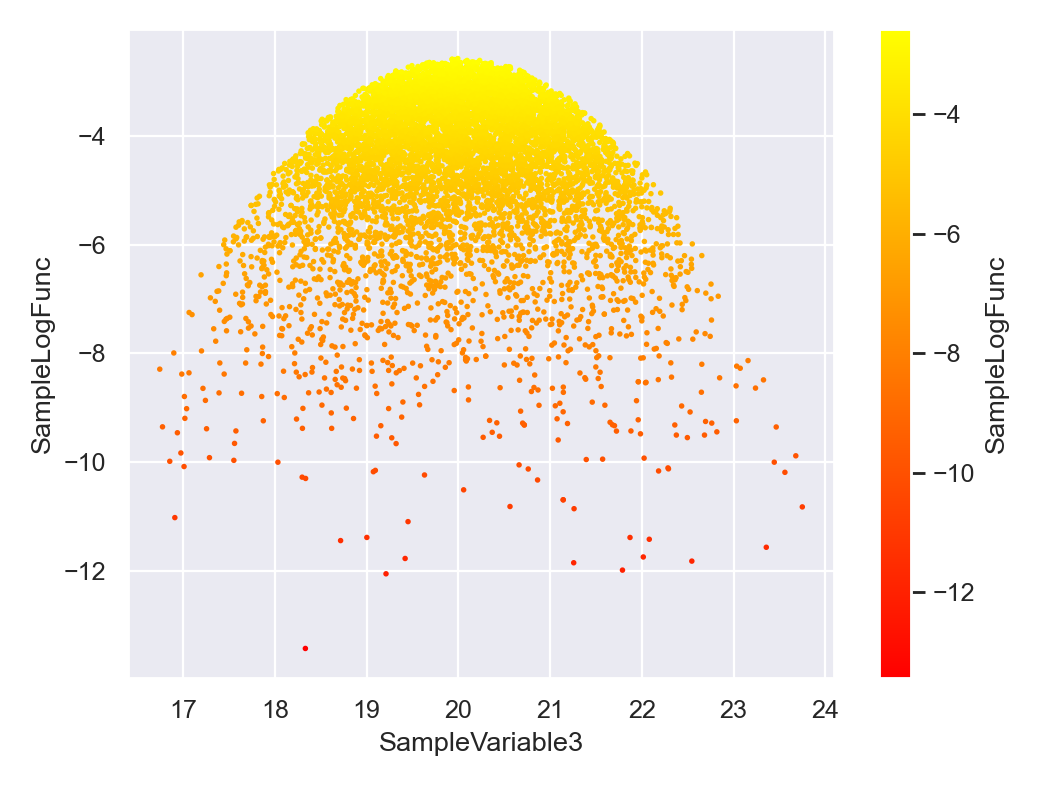

done in 0.120599 seconds.
ParaDRAM - NOTE: making the scatter plot... 

<IPython.core.display.Javascript object>


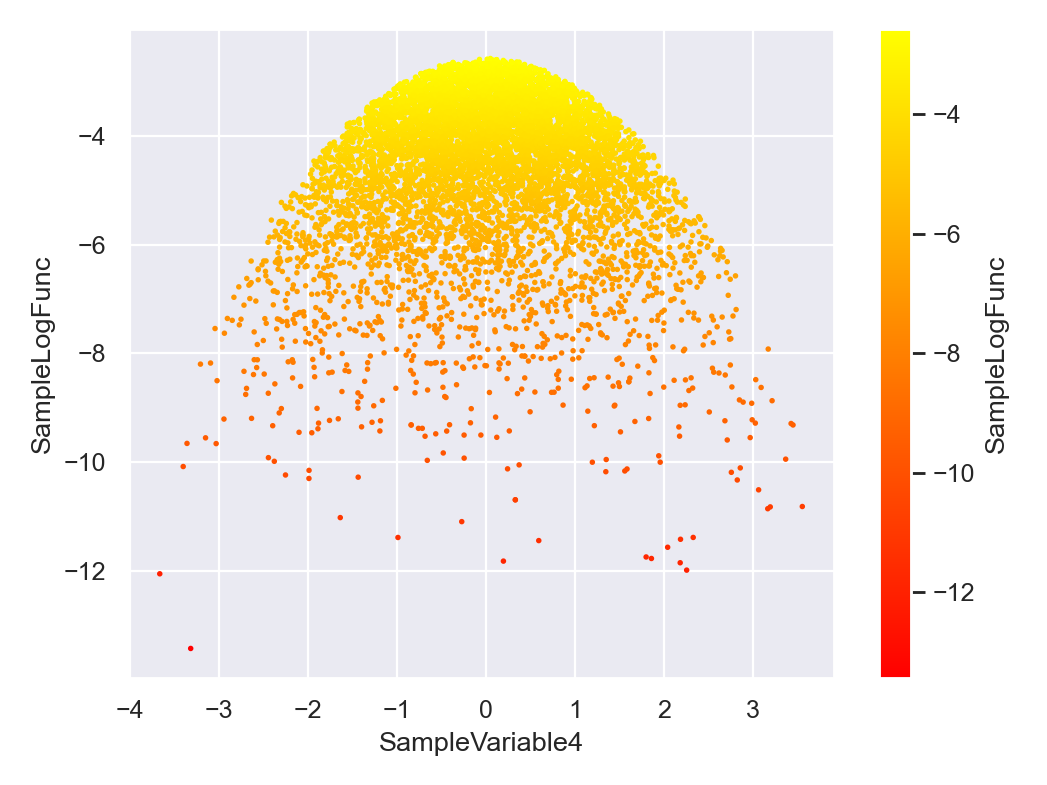

done in 0.168867 seconds.


In [32]:
sample.plot.scatter.reset()
sample.plot.scatter.ycolumns = "SampleLogFunc"
for variable in pmpd.sampleList[0].df.columns[1:]: # exclude the SampleLogFunc column
    sample.plot.scatter.xcolumns = variable
    sample.plot.scatter()

To make bivariate plots of sampled variables against each other, instead of traceplots, simply specify the columns of data to plot,

ParaDRAM - NOTE: making the lineScatter plot... 

<IPython.core.display.Javascript object>


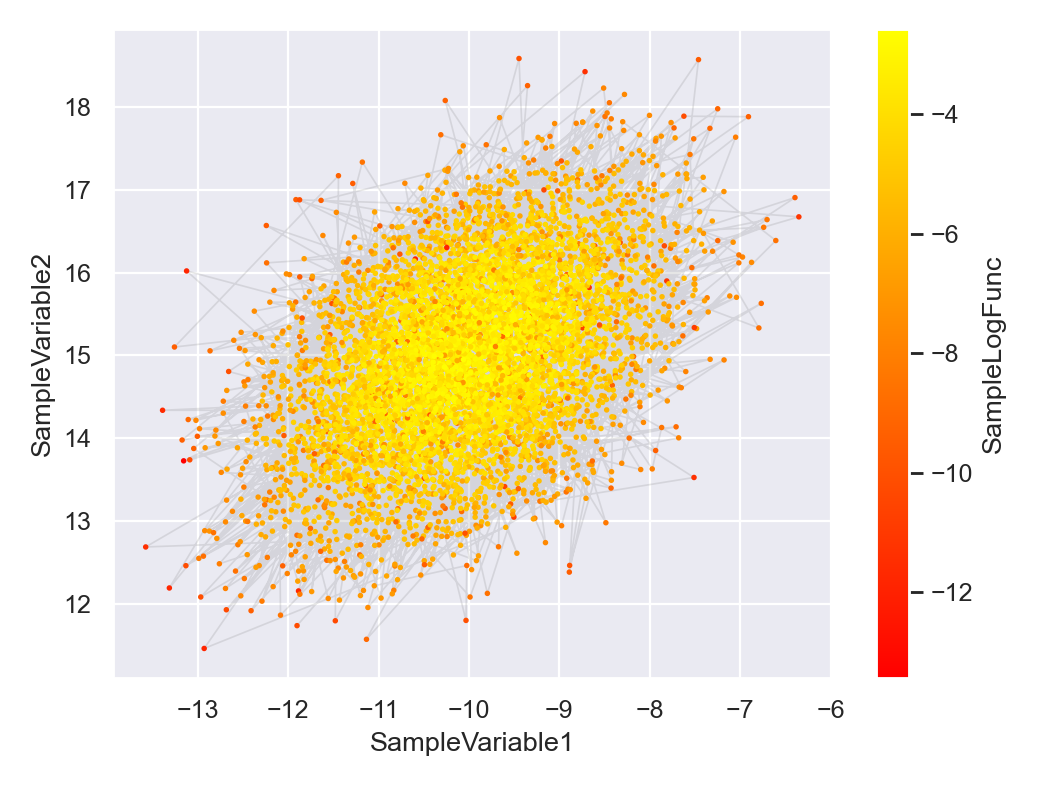

done in 0.130472 seconds.


In [33]:
sample.plot.lineScatter( xcolumns = 1, ycolumns = 2)

To make 3D plots of data, we can try the ParaMonte 3D visualzation tools, like, `line3`, `scatter3`, or `lineScatter3`,

ParaDRAM - NOTE: making the lineScatter3 plot... 

<IPython.core.display.Javascript object>


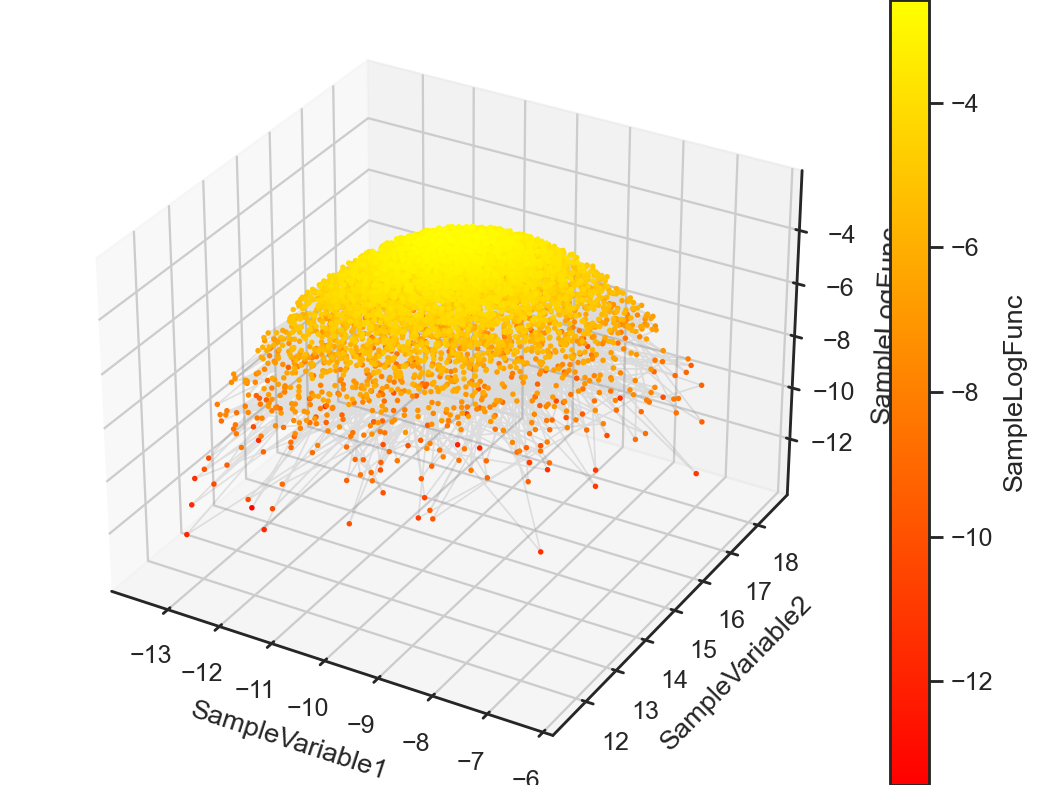

done in 0.079887 seconds.


In [34]:
sample.plot.lineScatter3()

To make kernel density contour plots of the sampled points, we can try 

ParaDRAM - NOTE: making the contour plot... 

<IPython.core.display.Javascript object>


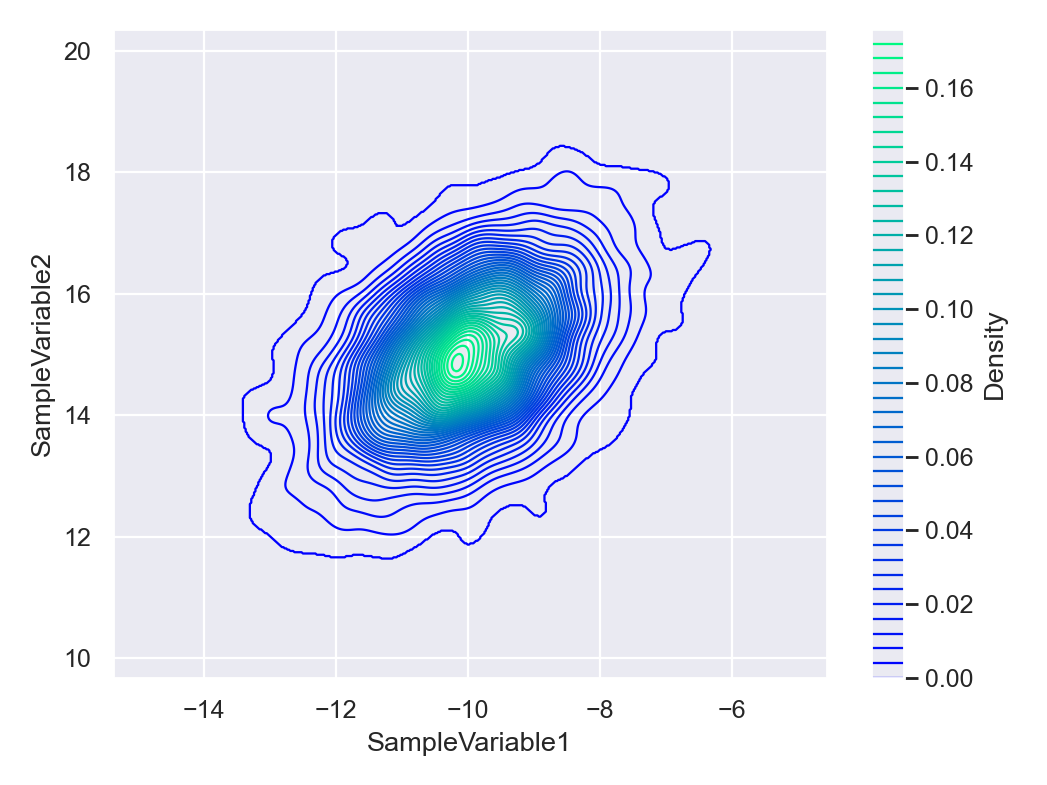

done in 0.419885 seconds.


In [35]:
sample.plot.contour()

To make kernel density filled contour plots of the sampled points, we can try,

ParaDRAM - NOTE: making the contourf plot... 

<IPython.core.display.Javascript object>


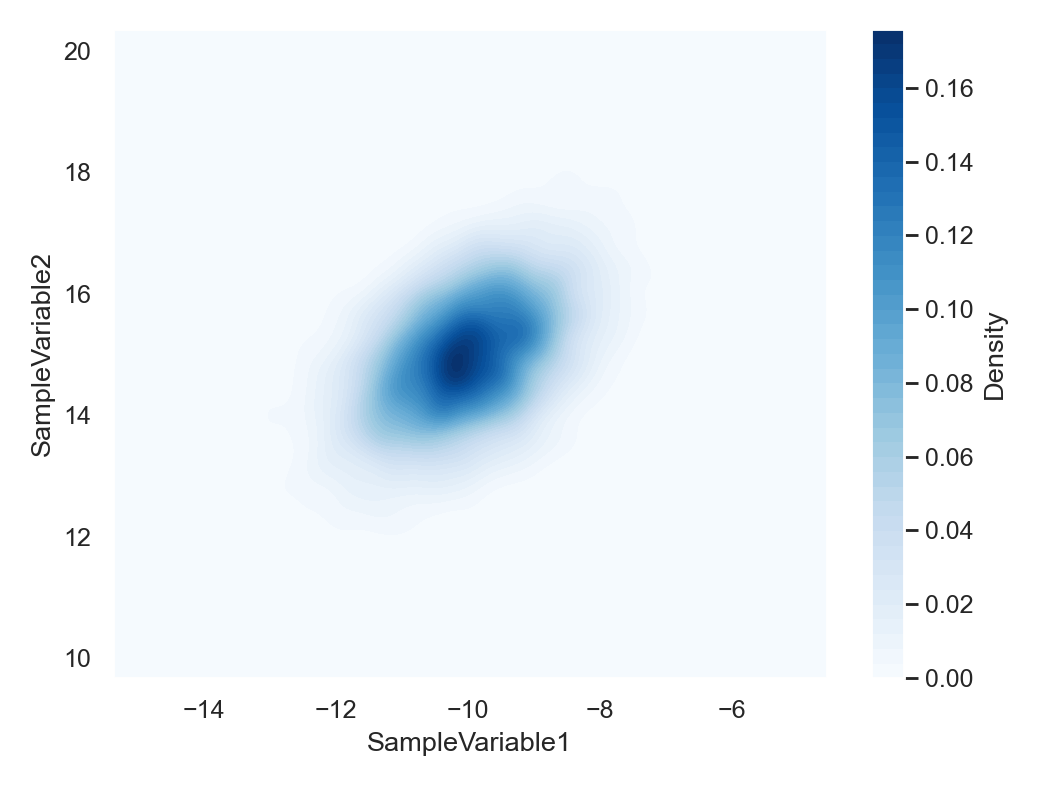

done in 0.429899 seconds.


In [36]:
sample.plot.contourf()

Let's add the mode of the distribution as target to the distribution, too,  

ParaDRAM - NOTE: making the contourf plot... 

<IPython.core.display.Javascript object>


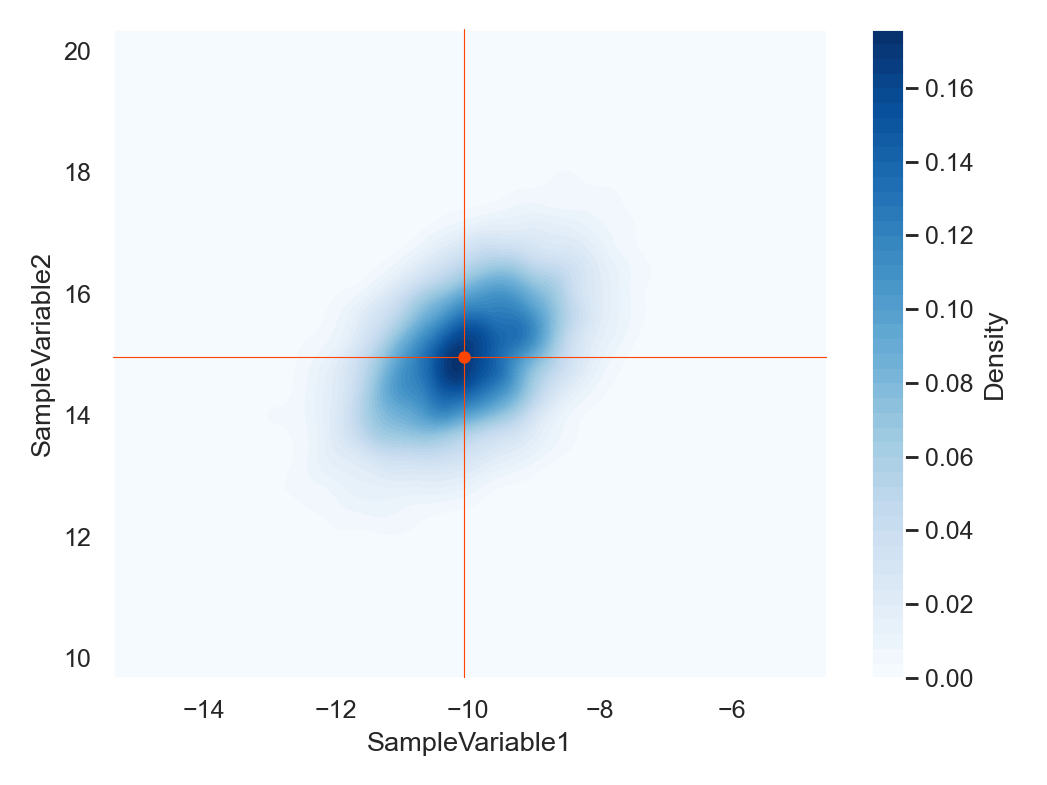

done in 0.414798 seconds.


In [37]:
sample.plot.contourf()
sample.plot.contourf.target()

ParaDRAM - NOTE: making the contourf plot... 

<IPython.core.display.Javascript object>


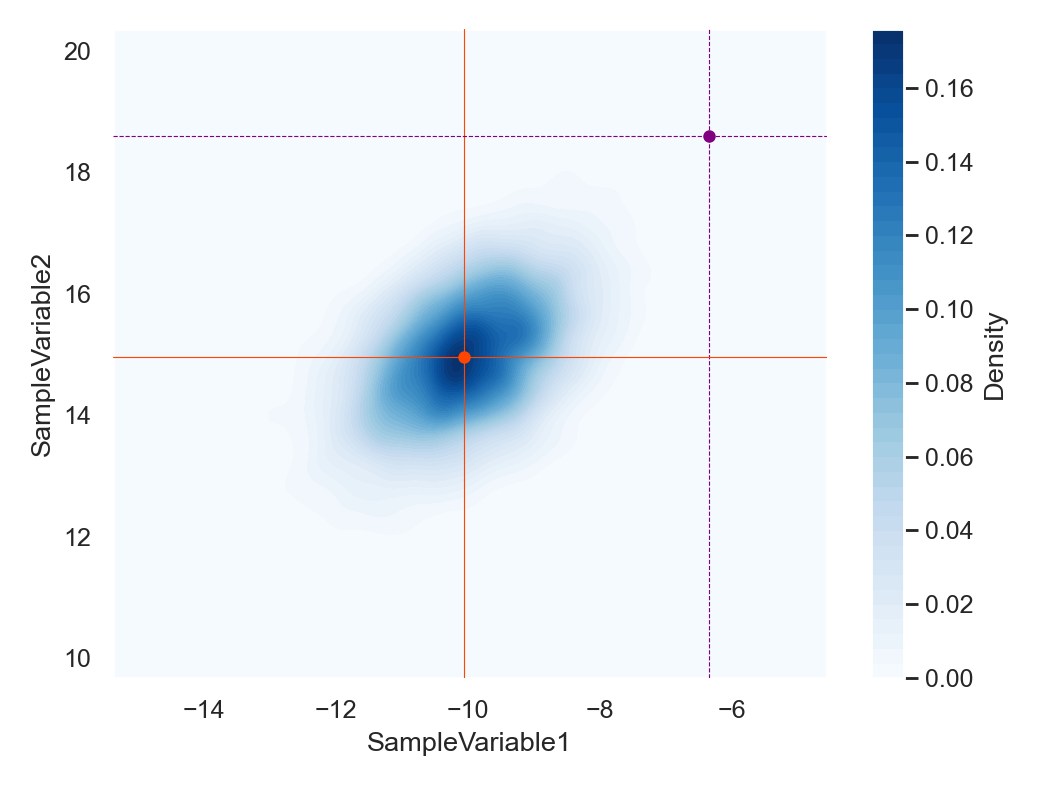

done in 0.419707 seconds.


In [38]:
sample.plot.contourf.reset()
sample.plot.contourf()
sample.plot.contourf.target()

we could add as many target as desired. For example, let's add the point corresponding to the maximum of the two variables in the above plot, and let's give it a purple color,    

In [39]:
max1 = sample.df.SampleVariable1.max()
max2 = sample.df.SampleVariable2.max()
sample.plot.contourf.target.axvline.kws.linestyle = "--"
sample.plot.contourf.target.axhline.kws.linestyle = "--"
sample.plot.contourf.target.axvline.kws.color = "purple"
sample.plot.contourf.target.axhline.kws.color = "purple"
sample.plot.contourf.target.scatter.kws.color = "purple"
sample.plot.contourf.target( value  = [max1, max2] )

To make 3D kernel density contour plots of the sampled points, we can try,

ParaDRAM - NOTE: making the contour3 plot... 

<IPython.core.display.Javascript object>


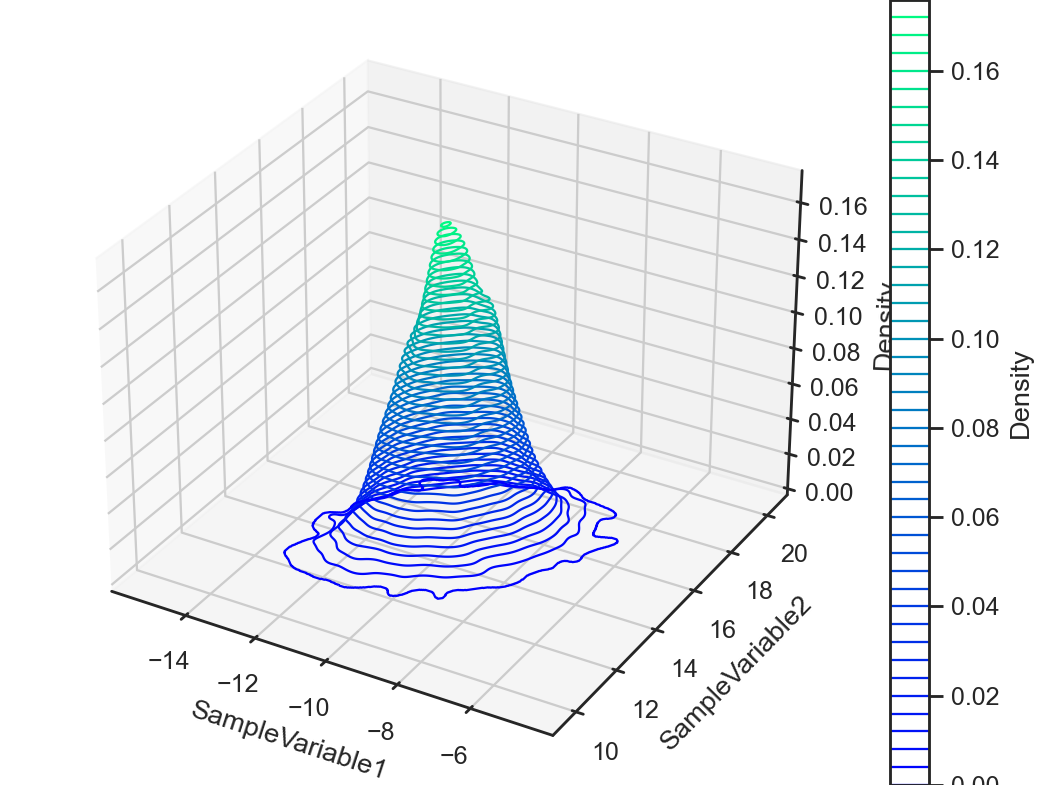

done in 0.490094 seconds.


In [40]:
sample.plot.contour3()

By default, the kernel density plot displays `SampleVariable2` vs. `SampleVariable1`, if no other specifications are made by the user.

There are also the `kdeplot1()` and `kdeplot2()` visualization tools that make calls to the `kdeplot()` function of the seaborn library. However, those function implementations in seaborn are currently computationally too slow and therefore we will not diplay them here, though you can try them by yourself.

There is also the ParaMonte `jointplot()` visualization tool which implicitly calls the `jointplot()` function of the seaborn library.

ParaDRAM - NOTE: making the jointplot plot... 

<IPython.core.display.Javascript object>


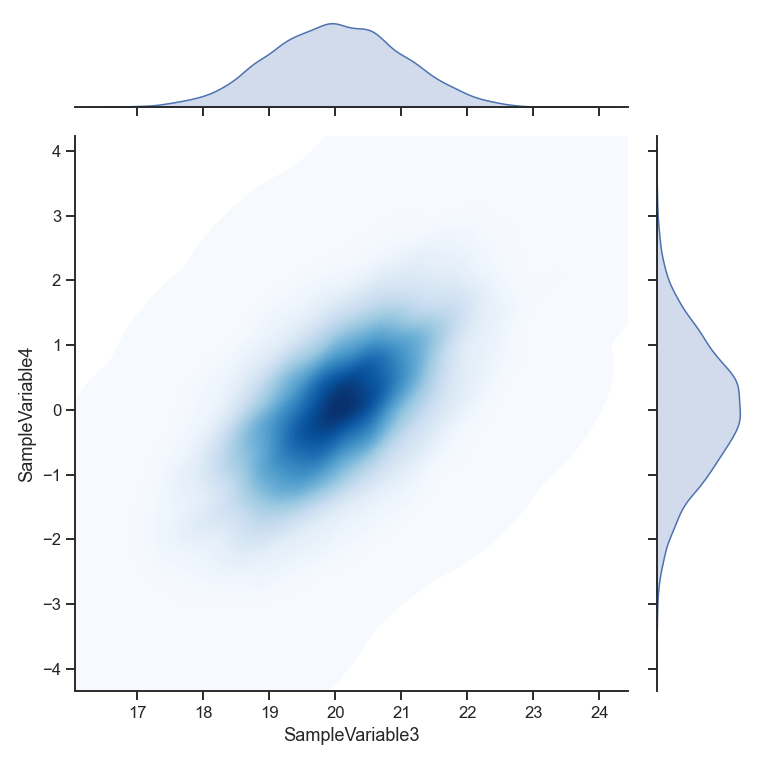

done in 5.338551 seconds.


In [41]:
sample.plot.jointplot(xcolumns = 3, ycolumns = 4)

We can also make a grid plot of all of the variables against each other via,  

ParaDRAM - NOTE: making the grid plot... 


<IPython.core.display.Javascript object>


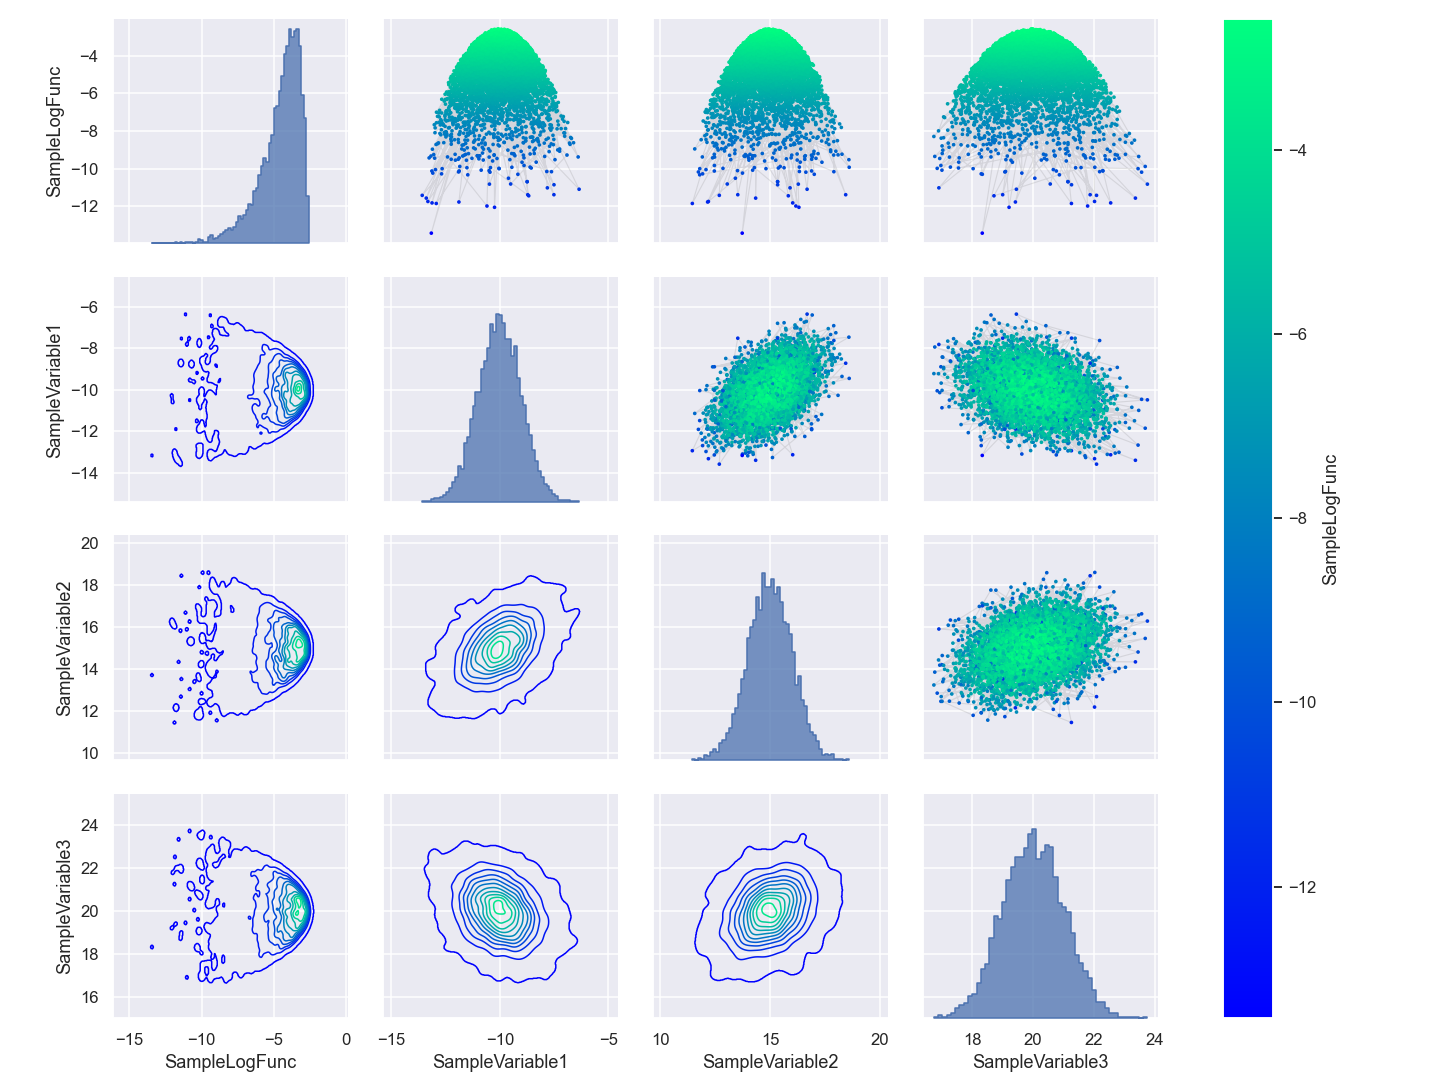

generating subplot #1: (0,0) out of 16... done in 0.037472 seconds.
generating subplot #2: (0,1) out of 16... done in 0.229825 seconds.
generating subplot #3: (0,2) out of 16... done in 0.195695 seconds.
generating subplot #4: (0,3) out of 16... done in 0.184454 seconds.
generating subplot #5: (1,0) out of 16... done in 0.380014 seconds.
generating subplot #6: (1,1) out of 16... done in 0.037472 seconds.
generating subplot #7: (1,2) out of 16... done in 0.204834 seconds.
generating subplot #8: (1,3) out of 16... done in 0.195063 seconds.
generating subplot #9: (2,0) out of 16... done in 0.375278 seconds.
generating subplot #10: (2,1) out of 16... done in 0.334944 seconds.
generating subplot #11: (2,2) out of 16... done in 0.037472 seconds.
generating subplot #12: (2,3) out of 16... done in 0.199873 seconds.
generating subplot #13: (3,0) out of 16... done in 0.369917 seconds.
generating subplot #14: (3,1) out of 16... done in 0.372043 seconds.
generating subplot #15: (3,2) out of 16... 

In [42]:
sample.plot.grid()

By default, since the grid plot is rather computationally demanding, the grid plot adds only up to 5 columns of data to the grid plot,  

In [43]:
sample.plot.grid.columns

Index(['SampleLogFunc', 'SampleVariable1', 'SampleVariable2',
       'SampleVariable3'],
      dtype='object')

This behavior can be overriden by the user by assigning more or less columns of the data to the `columns` atribute of the grid plot, like,  

ParaDRAM - NOTE: making the grid plot... 


<IPython.core.display.Javascript object>


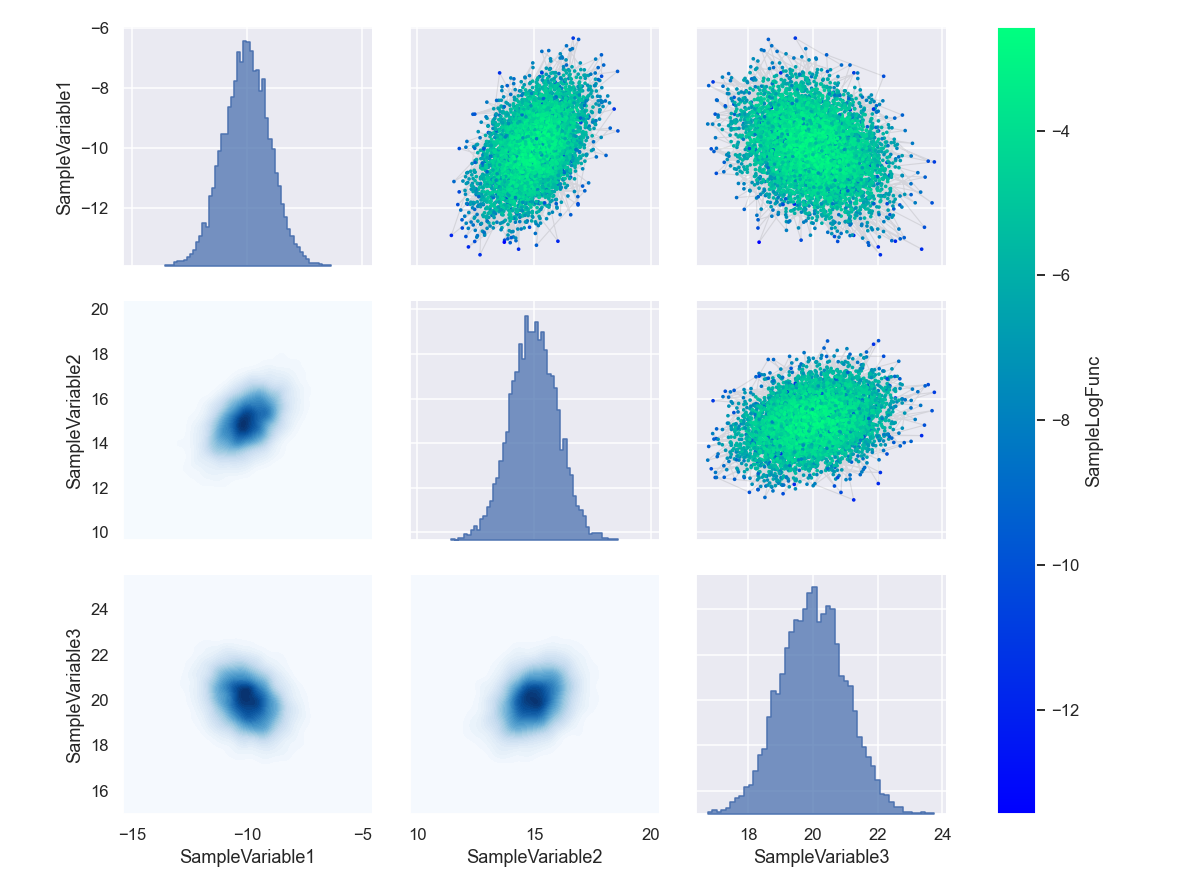

generating subplot #1: (0,0) out of 9... done in 0.04039 seconds.
generating subplot #2: (0,1) out of 9... done in 0.158675 seconds.
generating subplot #3: (0,2) out of 9... done in 0.141357 seconds.
generating subplot #4: (1,0) out of 9... done in 0.42839 seconds.
generating subplot #5: (1,1) out of 9... done in 0.04039 seconds.
generating subplot #6: (1,2) out of 9... done in 0.140113 seconds.
generating subplot #7: (2,0) out of 9... done in 0.406111 seconds.
generating subplot #8: (2,1) out of 9... done in 0.404135 seconds.
generating subplot #9: (2,2) out of 9... done in 0.04039 seconds.
generating colorbar... done in 0.019732 seconds.


In [44]:
sample.plot.grid.columns = [1,2,3] # indices and column names can be mixed
sample.plot.grid.plotType.lower.value = "contourf"
sample.plot.grid()

If one corner of the plot is not needed, we cal also simply hide it by disabling it,

ParaDRAM - NOTE: making the grid plot... 


<IPython.core.display.Javascript object>


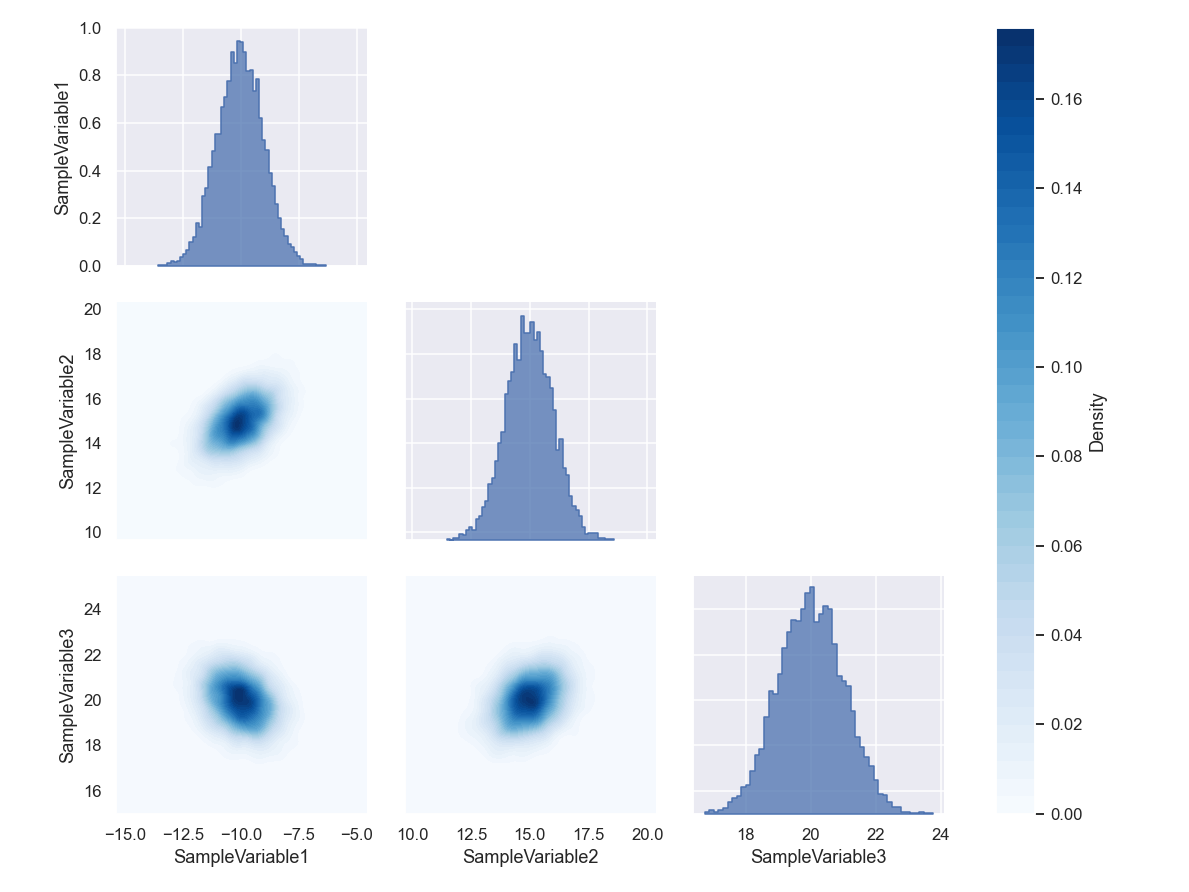

generating subplot #1: (0,0) out of 9... done in 0.039373 seconds.
generating subplot #2: (0,1) out of 9... done in 0.0 seconds.
generating subplot #3: (0,2) out of 9... done in 0.0 seconds.
generating subplot #4: (1,0) out of 9... done in 0.415082 seconds.
generating subplot #5: (1,1) out of 9... done in 0.039373 seconds.
generating subplot #6: (1,2) out of 9... done in 0.0 seconds.
generating subplot #7: (2,0) out of 9... done in 0.400175 seconds.
generating subplot #8: (2,1) out of 9... done in 0.395026 seconds.
generating subplot #9: (2,2) out of 9... done in 0.039373 seconds.
generating colorbar... done in 0.029967 seconds.


In [45]:
sample.plot.grid.columns = [1,2,3] # indices and column names can be mixed
sample.plot.grid.plotType.lower.value = "contourf"
sample.plot.grid.plotType.upper.enabled = False # disable the upper triangle
sample.plot.grid()

You can also hide the upper or the lower triangles or the colorbar or all three within the current figure by using the "hide" method of the grid object,  

ParaDRAM - NOTE: making the grid plot... 


<IPython.core.display.Javascript object>


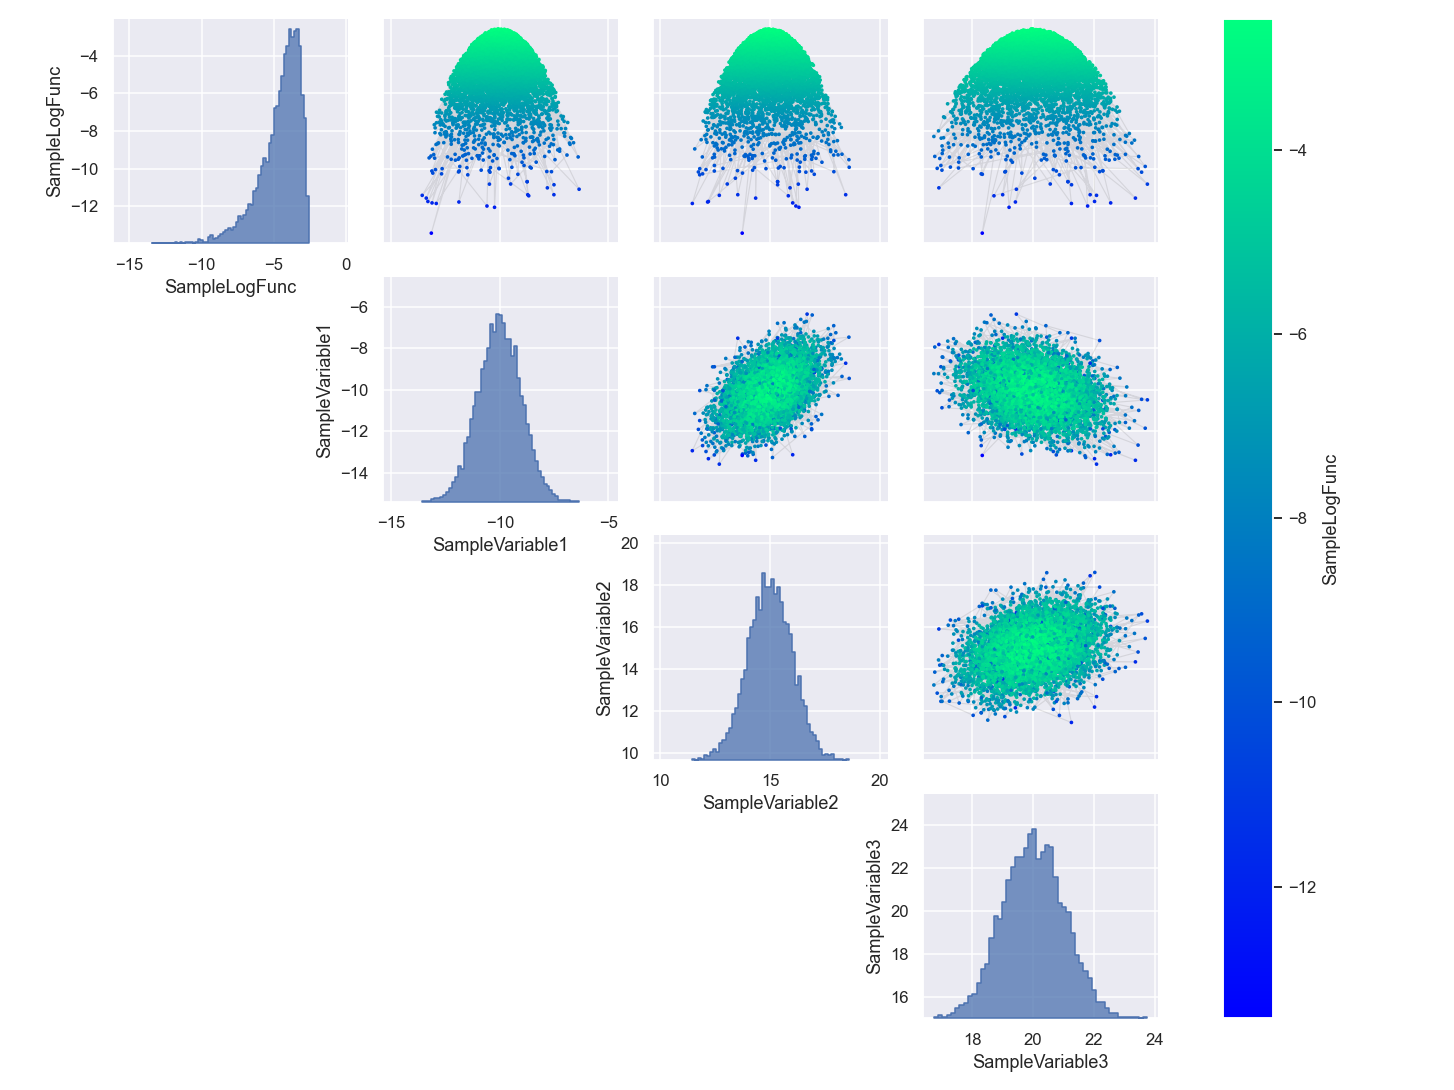

generating subplot #1: (0,0) out of 16... done in 0.044579 seconds.
generating subplot #2: (0,1) out of 16... done in 0.219849 seconds.
generating subplot #3: (0,2) out of 16... done in 0.209784 seconds.
generating subplot #4: (0,3) out of 16... done in 0.200379 seconds.
generating subplot #5: (1,0) out of 16... done in 0.369756 seconds.
generating subplot #6: (1,1) out of 16... done in 0.044579 seconds.
generating subplot #7: (1,2) out of 16... done in 0.199976 seconds.
generating subplot #8: (1,3) out of 16... done in 0.210042 seconds.
generating subplot #9: (2,0) out of 16... done in 0.369883 seconds.
generating subplot #10: (2,1) out of 16... done in 0.375229 seconds.
generating subplot #11: (2,2) out of 16... done in 0.044579 seconds.
generating subplot #12: (2,3) out of 16... done in 0.20502 seconds.
generating subplot #13: (3,0) out of 16... done in 0.359697 seconds.
generating subplot #14: (3,1) out of 16... done in 0.390032 seconds.
generating subplot #15: (3,2) out of 16... d

In [46]:
sample.plot.grid.reset()
sample.plot.grid()
sample.plot.grid.hide('lower')

To show the triangle again, you can call the `show()` method. To see what input options are available with `hide()` or `show()`, get help like the following,

In [47]:
sample.plot.grid.helpme("hide")



        Hides the requested part of the grid plot.

        **Parameters**

            part

                A string with the following possible values:

                    "lower"
                        hides the lower triangle of the grid plot.

                    "upper"
                        hides the upper triangle of the grid plot.

                    "diag"
                        hides the diagonal of the grid plot.

                    "all"
                        hides all grid plots and the colorbar.

                    "colorbar"
                        hides the colorbar of the grid plot.

                    The string can also be a mix of the above keywords,
                    separated by the ``+`` sign or some other delimiter.
                    For example, ``"lower+upper+colorbar"``

        **Returns**

            None

        


### Ensuring the independent and  identical distribution (i.i.d. property) of the resulting sample

We can more formally ensure the i.i.d. property of the resulting sample from the simulation by computing and visualizing the autocorrelation of the sampled points. Whenever a ParaDRAM output sample file is read, the sampler automatically computes the autocorrelation of sampled points along each dimension of the domain of the objective function.

ParaDRAM - NOTE: adding the autocrrelation graphics tools... 
ParaDRAM - NOTE: creating a line plot object from scratch... done in 0.0 seconds.
ParaDRAM - NOTE: creating a scatter plot object from scratch... done in 0.0 seconds.
ParaDRAM - NOTE: creating a lineScatter plot object from scratch... done in 0.0 seconds.
ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


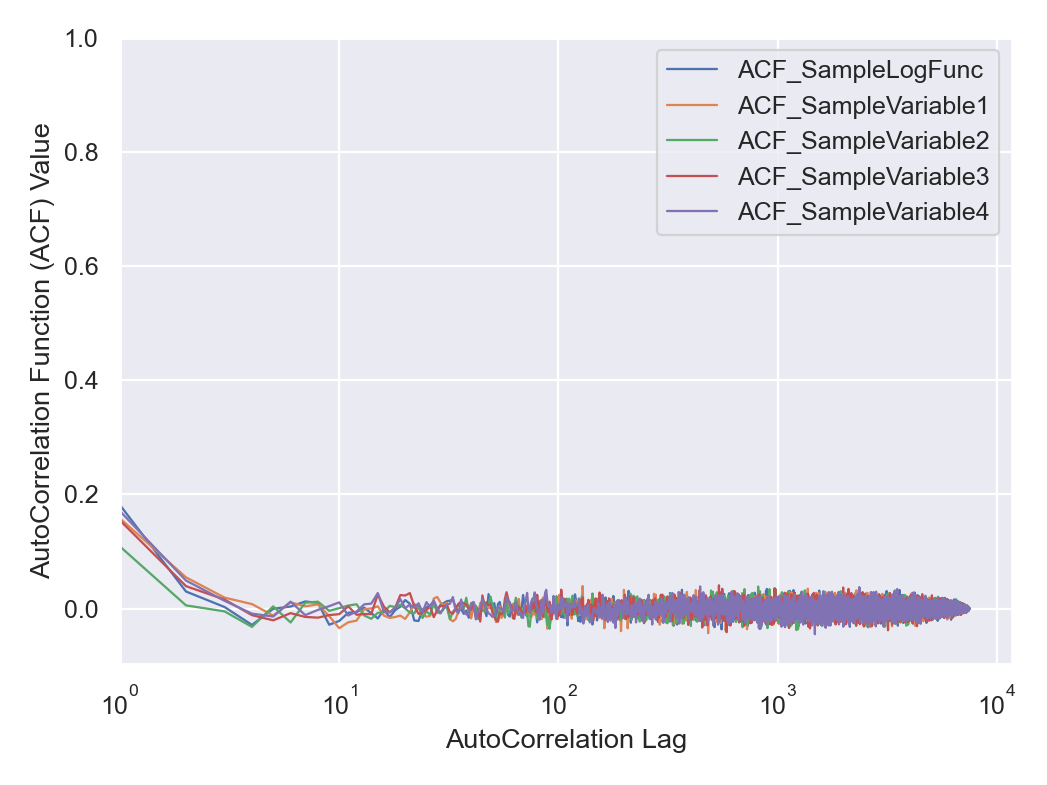

done in 0.270084 seconds.


In [48]:
sample.stats.autocorr()
sample.stats.autocorr.plot.line()

The above AutoCorrelation plot is reassuring since the sampled points do not appear to be correlated with each other at all. This is because the ParaDRAM routine, by default, applies many rounds aggressive refinement of the raw (verbose) Markov chain as it deems necessary to remove any residual correlations from the final output refined sample that we have plotted in the above.  

We can compare the autocorrelation of the refined sample in the above with the autocorrelation of the raw (verbose) Markov chain,  

In [49]:
markovChainList = pmpd.readMarkovChain(renabled = True) # object return enabled.
markovChain = markovChainList[0]


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readMarkovchain()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the chain file(s) to be parsed.


ParaDRAM - NOTE: 1 files detected matching the pattern: "./sampling_multivariate_normal_density_function_via_paradram/mvn_serial*_chain.txt"


ParaDRAM - NOTE: processing chain file: D:\Dropbox\Projects\20180101_ParaMonte\paramontex\Python\Jupyter\sampling_multivariate_normal_density_function_via_paradram\mvn_serial_process_1_chain.txt
ParaDRAM - NOTE: reading the file contents... done in 3.489811 seconds.
ParaDRAM - NOTE: ndim = 4, count = 104075
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample correlation matrix... 
ParaD

ParaDRAM - NOTE: adding the autocrrelation graphics tools... 
ParaDRAM - NOTE: creating a line plot object from scratch... done in 0.0 seconds.
ParaDRAM - NOTE: creating a scatter plot object from scratch... done in 0.0 seconds.
ParaDRAM - NOTE: creating a lineScatter plot object from scratch... done in 0.0 seconds.
ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


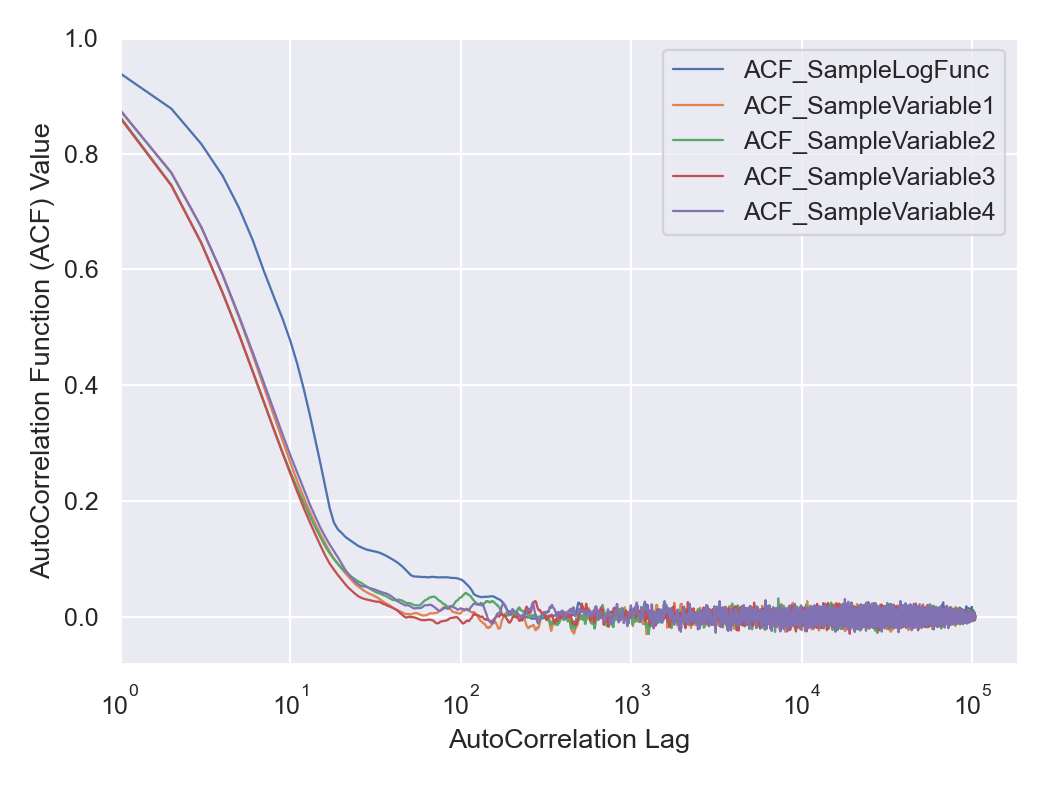

done in 0.534216 seconds.


In [50]:
markovChain.stats.autocorr()
markovChain.stats.autocorr.plot.line()

**Compare the above plot to the same plot that we got for the resulting refined samples earlier in the above**. Unlike the refined sample, the Markov chain is significantly correlated with itself along each dimension. The large amount of autocorrelation seen for `SampleLogFunc` is because of the fact that we started the MCMC sampling from a very bad low-probability location, which is also visible the grid plots in the above.

### Obtaining the summary statistics of the simulation results  

To get the statistics of the maximum of the function, try,

In [54]:
print( "maxLogFunc: {}".format(sample.stats.maxLogFunc.value) )
print( "The location of maxLogFunc: {}".format(sample.stats.maxLogFunc.state.values) )

maxLogFunc: -2.5751582
The location of maxLogFunc: [-10.060528    14.949581    19.994062     0.04765628]


which is again reassuring, since we already know that the maximum of the standard Gaussian distribution happens at zero, which is very close to the ParaDRAM sampler's estimated location of `maxLogFunc` in the above.

Further statistics of the resulting sample and the raw verbose Markov chain can be computed from the dataFrame. For example, via,  

In [55]:
sample.df.describe()

SampleLogFunc  SampleVariable1  SampleVariable2  SampleVariable3  \
count    7504.000000      7504.000000      7504.000000      7504.000000   
mean       -4.573896       -10.025751        14.981440        20.012209   
std         1.417971         0.995760         1.002555         1.003504   
min       -13.430980       -13.575107        11.456387        16.745422   
25%        -5.259487       -10.695753        14.299378        19.309565   
50%        -4.234739       -10.021130        14.986970        20.004113   
75%        -3.532682        -9.340668        15.662927        20.690255   
max        -2.575158        -6.350774        18.592210        23.749184   

       SampleVariable4  
count      7504.000000  
mean          0.016573  
std           1.007613  
min          -3.664305  
25%          -0.666352  
50%           0.019996  
75%           0.689358  
max           3.549447

Some statistics are also automatically computed and reported in the output report file of every ParaDRAM simulation (which ends with the suffix `*_report.txt`). One can either directly inspect the contents of this file, or use the `readReport()` function of the ParaDRAM sampler object, like,  

In [56]:
reportList = pmpd.readReport(renabled = True) # object return enabled
report = reportList[0]


ParaDRAM - NOTE: 1 files detected matching the pattern: "./sampling_multivariate_normal_density_function_via_paradram/mvn_serial*_report.txt"


ParaDRAM - NOTE: processing report file: D:\Dropbox\Projects\20180101_ParaMonte\paramontex\Python\Jupyter\sampling_multivariate_normal_density_function_via_paradram\mvn_serial_process_1_report.txt
ParaDRAM - NOTE: reading the file contents... ParaDRAM - NOTE: parsing the report file contents...
done in 0.008198 seconds.

ParaDRAM - NOTE: The processed report files are now stored in the output variable as a
ParaDRAM - NOTE: Python list. For example, to access the contents of the first (or the only) 
ParaDRAM - NOTE: report file stored in an output variable named reportList, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     reportList[0].contents.print()
ParaDRAM - NOTE: 
ParaDRAM - NOTE: where you will have to replace `pmpd` with your ParaDRAM instance name.
ParaDRAM - NOTE: To access the simulation statistics and information, examine the contents of

In [57]:
print(report.stats.chain.refined.ess.value)
print(report.stats.chain.refined.ess.description)

7504
This is the estimated Effective (decorrelated) Sample Size (ESS) of the final refined chain.


### Monitoring and ensuring the diminishing adaptation criterion of the 

Now, to see the effects of setting the starting point of the MCMC sampler, we will take a look at the full chain (in compact form) of **uniquely sampled points** form the objective function,

In [58]:
pmpd.readChain()
chain = pmpd.chainList[0]


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readChain()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the chain file(s) to be parsed.


ParaDRAM - NOTE: 1 files detected matching the pattern: "./sampling_multivariate_normal_density_function_via_paradram/mvn_serial*_chain.txt"


ParaDRAM - NOTE: processing chain file: D:\Dropbox\Projects\20180101_ParaMonte\paramontex\Python\Jupyter\sampling_multivariate_normal_density_function_via_paradram\mvn_serial_process_1_chain.txt
ParaDRAM - NOTE: reading the file contents... done in 0.049837 seconds.
ParaDRAM - NOTE: ndim = 4, count = 30000
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample correlation matrix... 
ParaDRAM - N

Just as with the refined sample, we can also make the same types of plots for the compact and verbose (Markov) chains, for example, a grid plot,  

In [59]:
chain.df.head()

ProcessID  DelayedRejectionStage  MeanAcceptanceRate  AdaptationMeasure  \
0          1                      0            1.000000                0.0   
1          1                      0            0.666667                0.0   
2          1                      0            0.600000                0.0   
3          1                      0            0.571429                0.0   
4          1                      0            0.625000                0.0   

   BurninLocation  SampleWeight  SampleLogFunc  SampleVariable1  \
0               1             1     -329.22317         0.000000   
1               1             2     -319.38776        -1.131467   
2               2             2     -292.87086        -2.708690   
3               3             2     -290.73338        -4.913328   
4               4             1     -246.42733        -6.311880   

   SampleVariable2  SampleVariable3  SampleVariable4  
0         0.000000         0.000000         0.000000  
1        -1.011470         2.440997        -1.638004  
2        -1.746430         2.887417         0.428331  
3        -2.901997         2.351047        -0.017945  
4        -1.069209         3.394714         0.746134

ParaDRAM - NOTE: making the grid plot... 


<IPython.core.display.Javascript object>


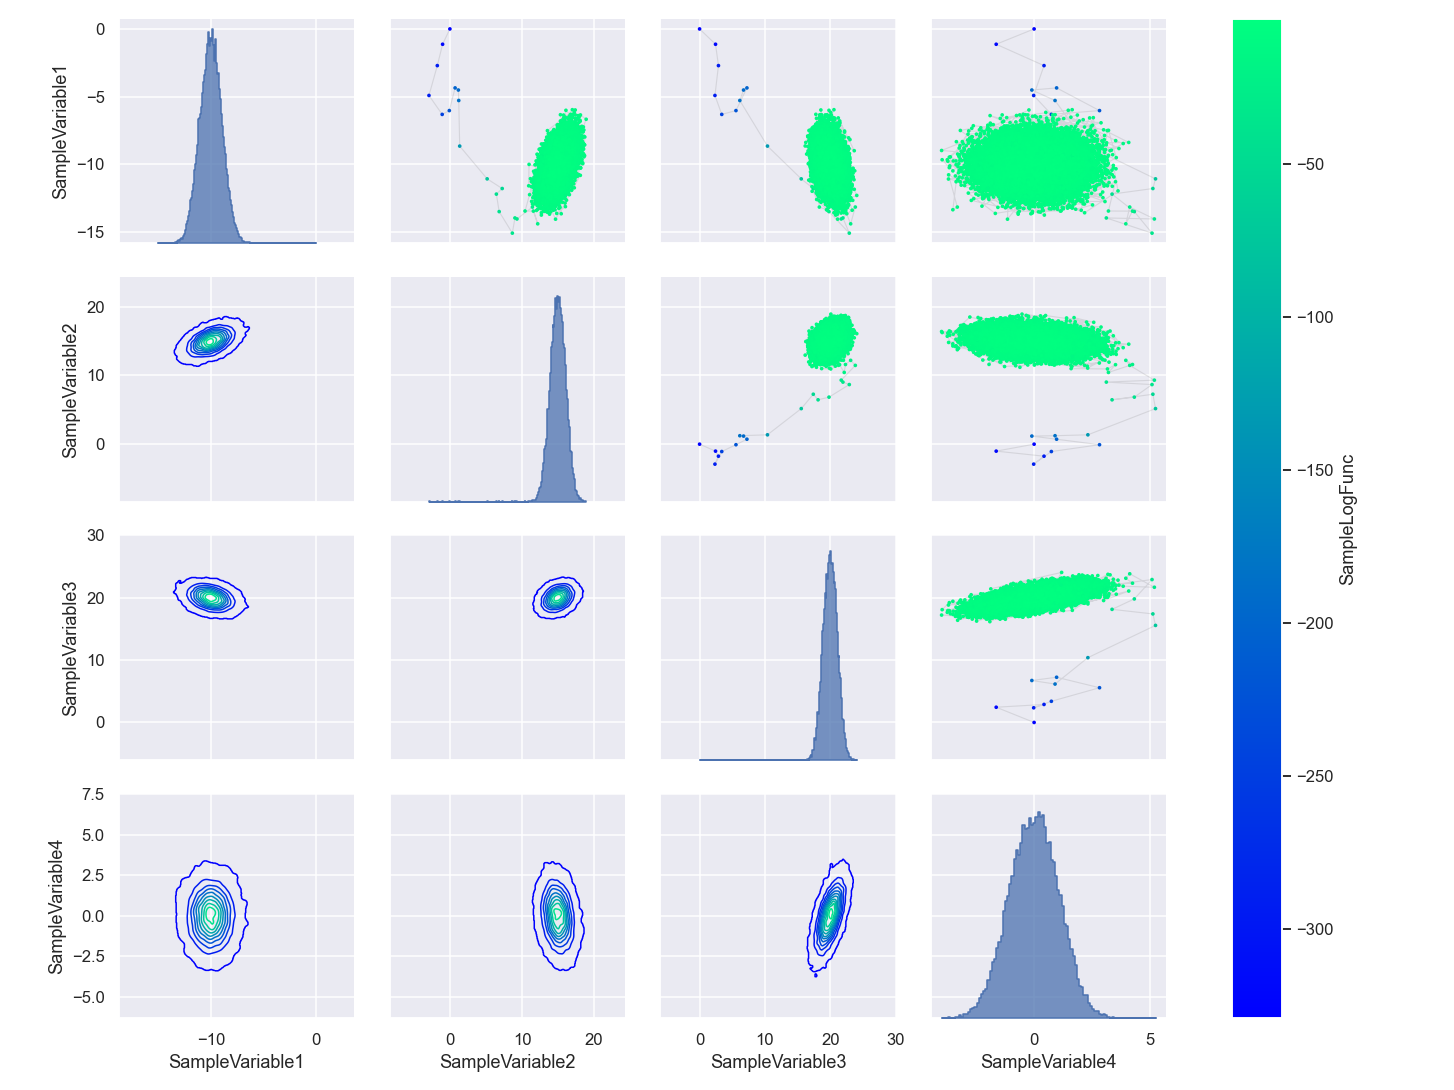

generating subplot #1: (0,0) out of 16... done in 0.041314 seconds.
generating subplot #2: (0,1) out of 16... done in 0.276994 seconds.
generating subplot #3: (0,2) out of 16... done in 0.252628 seconds.
generating subplot #4: (0,3) out of 16... done in 0.239855 seconds.
generating subplot #5: (1,0) out of 16... done in 0.390297 seconds.
generating subplot #6: (1,1) out of 16... done in 0.041314 seconds.
generating subplot #7: (1,2) out of 16... done in 0.234676 seconds.
generating subplot #8: (1,3) out of 16... done in 0.255323 seconds.
generating subplot #9: (2,0) out of 16... done in 0.369748 seconds.
generating subplot #10: (2,1) out of 16... done in 0.359904 seconds.
generating subplot #11: (2,2) out of 16... done in 0.041314 seconds.
generating subplot #12: (2,3) out of 16... done in 0.252185 seconds.
generating subplot #13: (3,0) out of 16... done in 0.357965 seconds.
generating subplot #14: (3,1) out of 16... done in 0.360227 seconds.
generating subplot #15: (3,2) out of 16... 

In [60]:
chain.plot.grid(columns = [7,8,9,10]) # plot SampleVariable1 to SampleVariable4

We can also add target values to this grid plot via the `addTarget()` method of the `GridPlot` object. By default, there are a few types target that are currently available out of the box, like `"mode"`, `"mean"`, `"median"`. The `"mode"` option corresponds to the state where the maximum of the objective function occurs. This is the default `value` if no `value` is provided to addTarget.

ParaDRAM - NOTE: making the grid plot... 


<IPython.core.display.Javascript object>


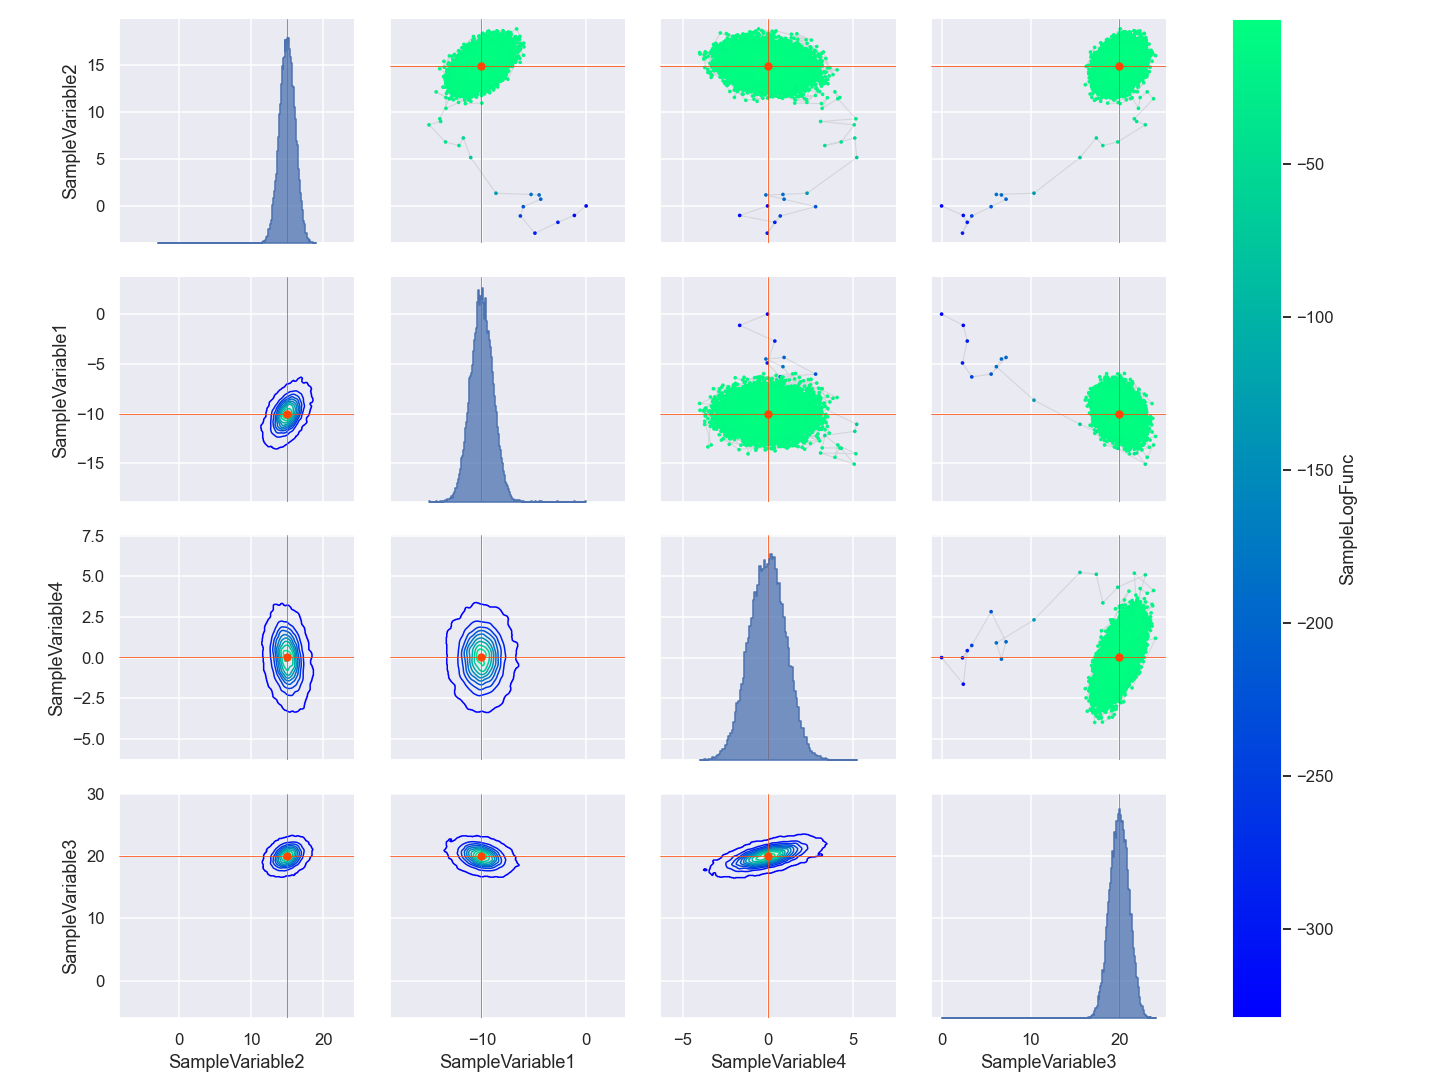

generating subplot #1: (0,0) out of 16... done in 0.039708 seconds.
generating subplot #2: (0,1) out of 16... done in 0.260053 seconds.
generating subplot #3: (0,2) out of 16... done in 0.260056 seconds.
generating subplot #4: (0,3) out of 16... done in 0.2499 seconds.
generating subplot #5: (1,0) out of 16... done in 0.390161 seconds.
generating subplot #6: (1,1) out of 16... done in 0.039708 seconds.
generating subplot #7: (1,2) out of 16... done in 0.256062 seconds.
generating subplot #8: (1,3) out of 16... done in 0.238947 seconds.
generating subplot #9: (2,0) out of 16... done in 0.380379 seconds.
generating subplot #10: (2,1) out of 16... done in 0.350003 seconds.
generating subplot #11: (2,2) out of 16... done in 0.039708 seconds.
generating subplot #12: (2,3) out of 16... done in 0.269769 seconds.
generating subplot #13: (3,0) out of 16... done in 0.350305 seconds.
generating subplot #14: (3,1) out of 16... done in 0.370004 seconds.
generating subplot #15: (3,2) out of 16... do

In [61]:
chain.plot.grid(columns = [8,7,10,9]) # plot in random order, just for illustration.
chain.plot.grid.addTarget()

The color in the scatter plots represents the value of `logFunc` at each point. The blue color of the density plots represents the density of the sampled points at any given location.  

 We can also add targets to these plots, representing a specific value of interest. For example, we may be interested in displaying the location of the maximum `logFunc` on these plots. This is the default value that is loaded on the targets when the `grid` object is created for the first time.

### Ensuring diminishing adaptation in the adaptive MCMC sampling

By default, the ParaDRAM sampler adapts the proposal distribution of the sampler throughout the entire simulation. This breaks the ergodicity condition of the Markov chain, however, **if** the adaptation tends to continuously and progressively diminish throughout the entire simulation, then we could potentially trust the Markov chain simulation results. The alternative is to simply turn off the adaptation, but that is rarely a good strategy. Instead, **a better solution is to keep the adaptivity on, however, simulate for a long-enough times to ensure convergence of the Markov chain to the target density has occurred**.  

**A unique feature of the ParaDRAM sampler** is that, it provides a measure of the amount of adaptation of the proposal distribution of the Markov chain by measuring how much the proposal distribution progressively changes throughout the simulation. In essence, the computed quantity, represented by the column **AdaptationMeasure** in the output chain files, represents an upper limit on the **total variation distance** between each updated proposal distribution and the last one used before it.  

We can plot the **AdaptationMeasure** for this sampling problem to ensure that the adaptation of the proposal distribution happens progressively less and less throughout the simulation. **If AdaptationMeasure does not diminish monotonically throughout the simulation, it would be a strong indication of the lack of convergence of the MCMC sampler to the target objective function**.

ParaDRAM - NOTE: making the scatter plot... 

<IPython.core.display.Javascript object>


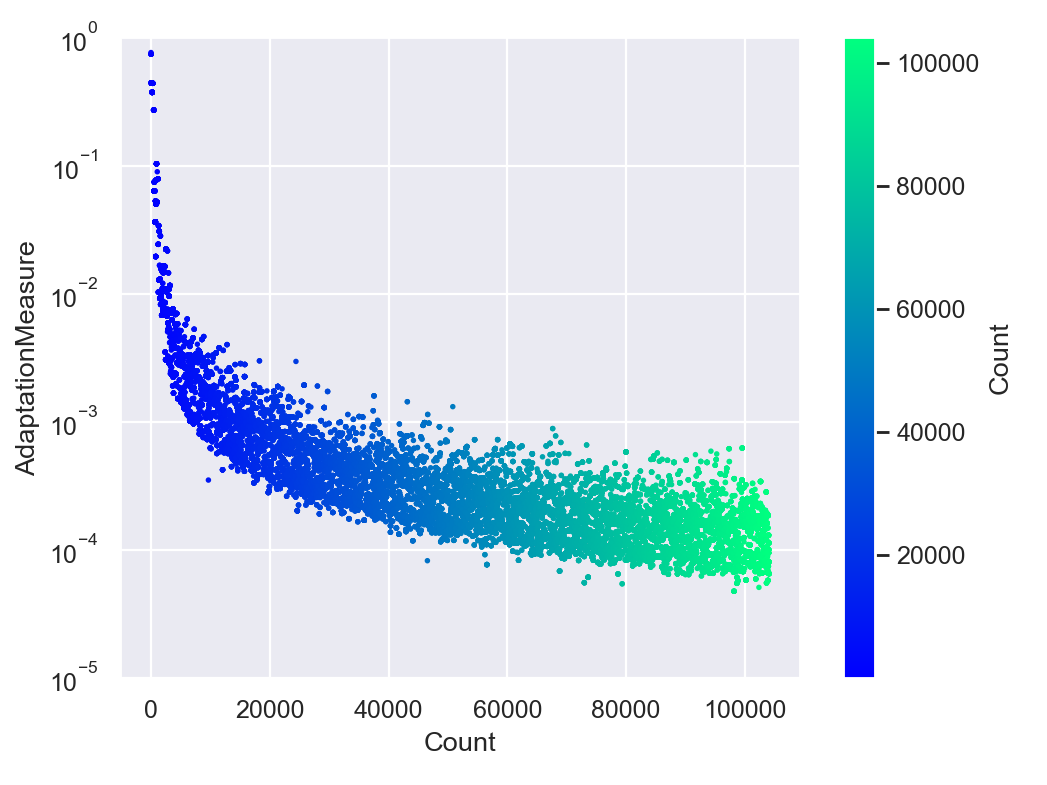

done in 0.200002 seconds.


(1e-05, 1)

In [62]:
markovChain.plot.scatter.scatter.kws.cmap = "winter"
markovChain.plot.scatter(ycolumns="AdaptationMeasure",ccolumns=[])
markovChain.plot.scatter.currentFig.axes.set_yscale("log")
markovChain.plot.scatter.currentFig.axes.set_ylim([1.e-5,1])

**The above curve is exactly the kind of diminishing adaptation that we would want to see in a ParaDRAM simulation**: At the beginning, the sampler appears to struggle for a while to find the shape of the target objective function, but around step 100, it appears to have found the peak of the target and starts to quickly converge and adapt the shape of the proposal distribution of the Markov Chain sampler to the shape of the objective function.

### Visualizing the adaptation of the proposal distribution of the ParaDRAM sampler  

We can also parse the contents of the **ASCII**-format restart file generated by the ParaDRAM sampler to gain insight into how the proposal distribution has been updated over the course of the simulation.  

In [63]:
restartList = pmpd.readRestart(renabled = True) # object return enabled.
restart = restartList[0]


ParaDRAM - NOTE: 1 files detected matching the pattern: "./sampling_multivariate_normal_density_function_via_paradram/mvn_serial*_restart.txt"


ParaDRAM - NOTE: processing restart file: D:\Dropbox\Projects\20180101_ParaMonte\paramontex\Python\Jupyter\sampling_multivariate_normal_density_function_via_paradram\mvn_serial_process_1_restart.txt
ParaDRAM - NOTE: reading the file contents... .
done in 0.361254 seconds.
ParaDRAM - NOTE: adding the graphics tools... 
ParaDRAM - NOTE: creating a line plot object from scratch... done in 0.0 seconds.
ParaDRAM - NOTE: creating a scatter plot object from scratch... done in 0.009969 seconds.
ParaDRAM - NOTE: creating a lineScatter plot object from scratch... done in 0.0 seconds.
ParaDRAM - NOTE: creating a covmat2 plot object from scratch... done in 0.0 seconds.
ParaDRAM - NOTE: creating a covmat3 plot object from scratch... done in 0.0 seconds.
ParaDRAM - NOTE: creating a cormat2 plot object from scratch... done in 0.0 seconds.
ParaDRAM - NOTE: c

ParaDRAM - NOTE: making the cormat2 plot... 

<IPython.core.display.Javascript object>


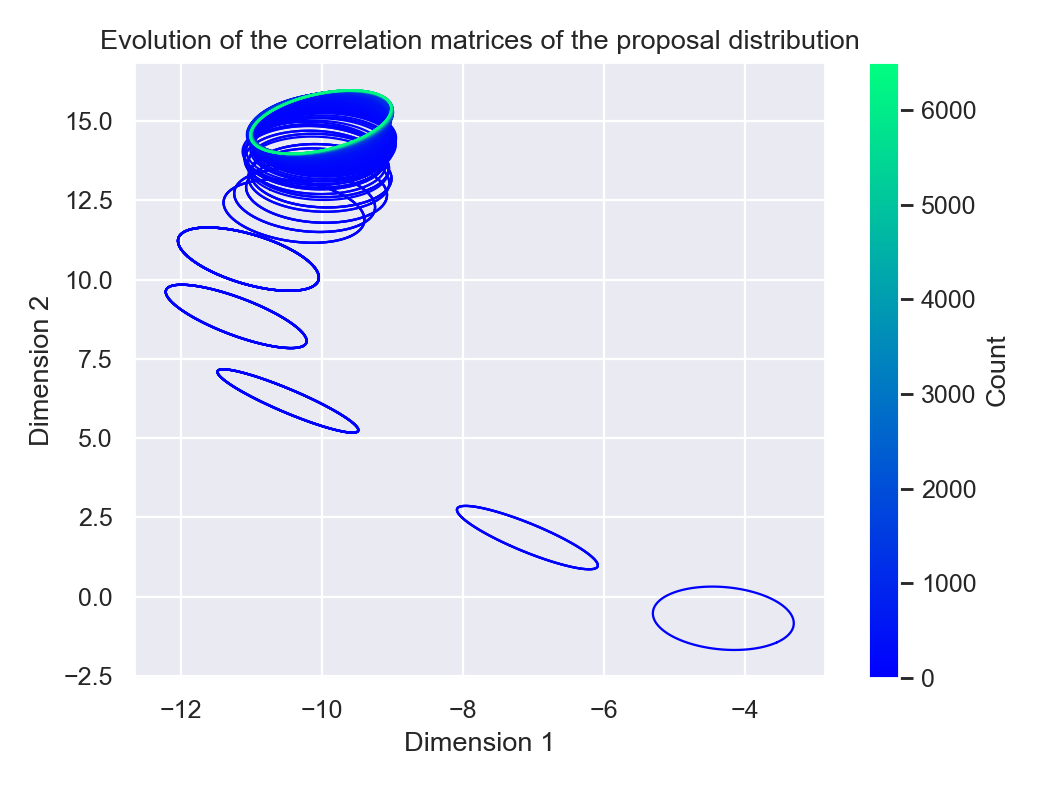

done in 0.309993 seconds.
ParaDRAM - NOTE: making the cormat2 plot... 

<IPython.core.display.Javascript object>


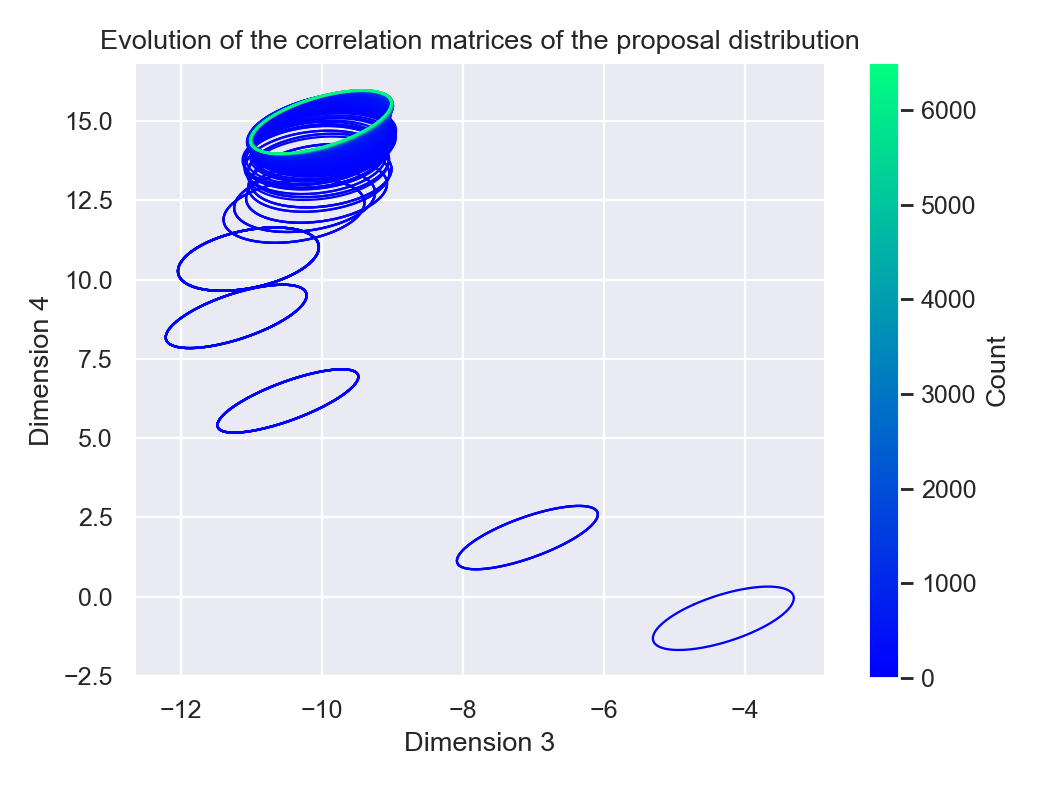

done in 0.295088 seconds.


In [64]:
restart.plot.cormat2.reset()
restart.plot.cormat2()

restart.plot.cormat2.reset()
restart.plot.cormat2(dimensionPair = [2,3])

ParaDRAM - NOTE: making the covmat2 plot... 

<IPython.core.display.Javascript object>


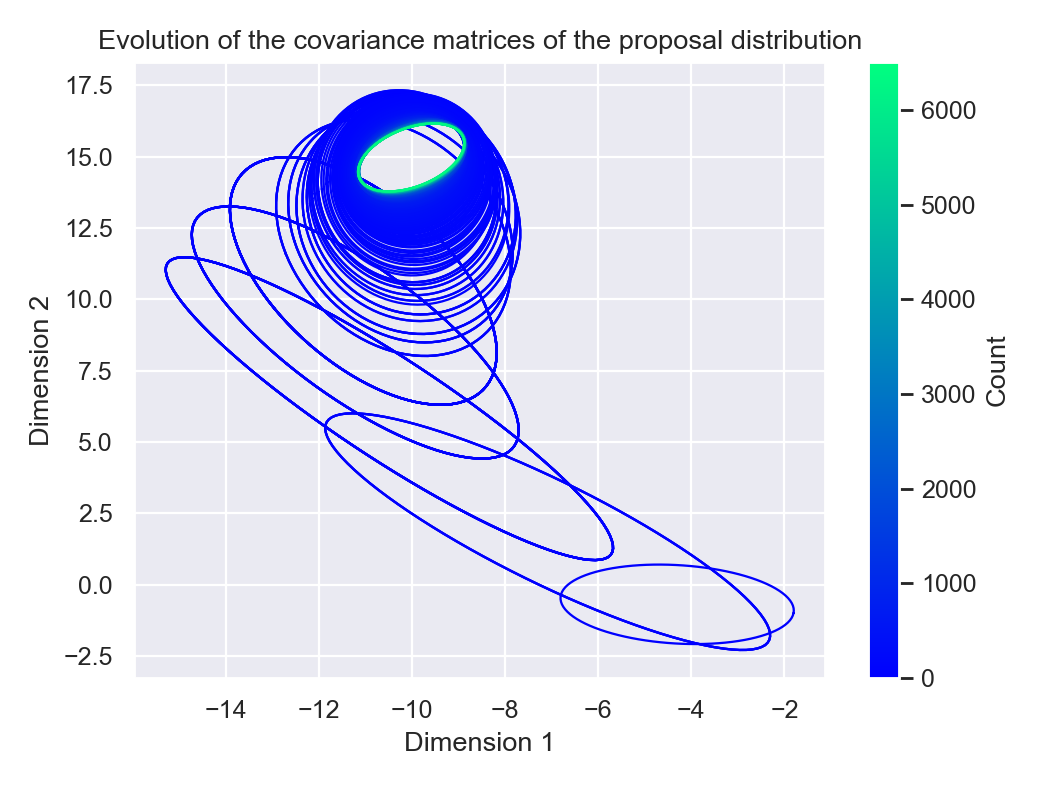

done in 0.309878 seconds.
ParaDRAM - NOTE: making the covmat2 plot... 

<IPython.core.display.Javascript object>


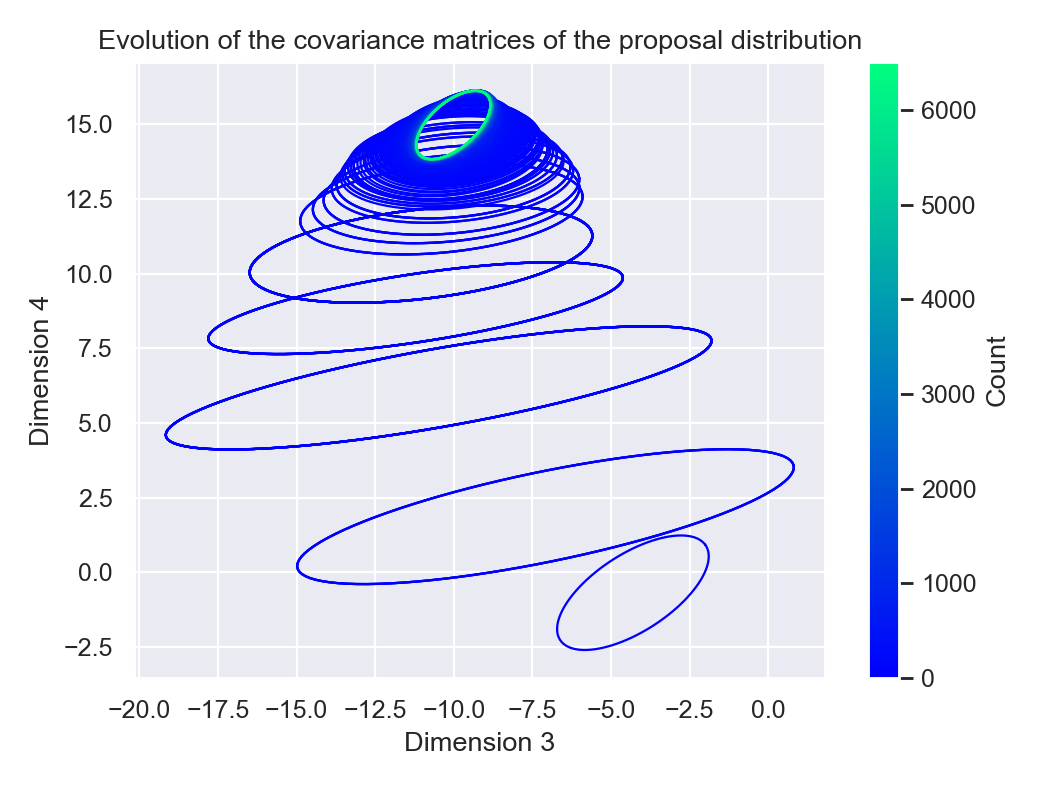

done in 0.300169 seconds.


In [65]:
restart.plot.covmat2.reset()
restart.plot.covmat2()

restart.plot.covmat2.reset()
restart.plot.covmat2(dimensionPair = [2,3])

ParaDRAM - NOTE: making the covmat3 plot... 

<IPython.core.display.Javascript object>


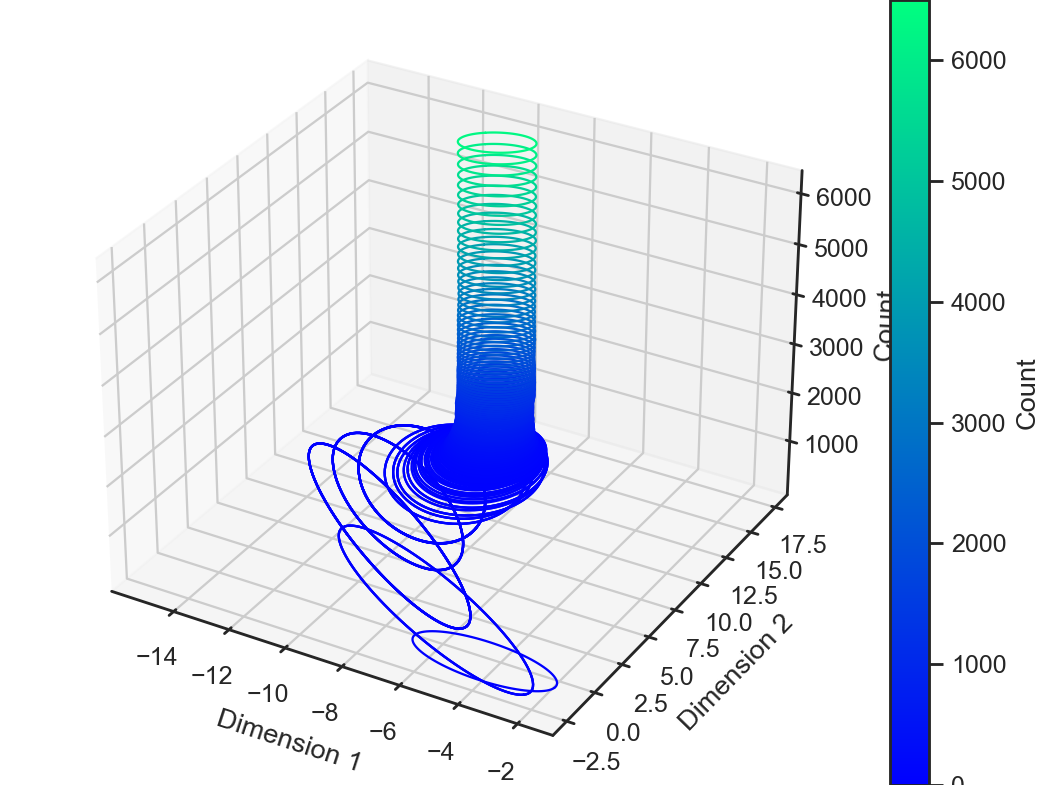

done in 0.289659 seconds.
ParaDRAM - NOTE: making the covmat3 plot... 

<IPython.core.display.Javascript object>


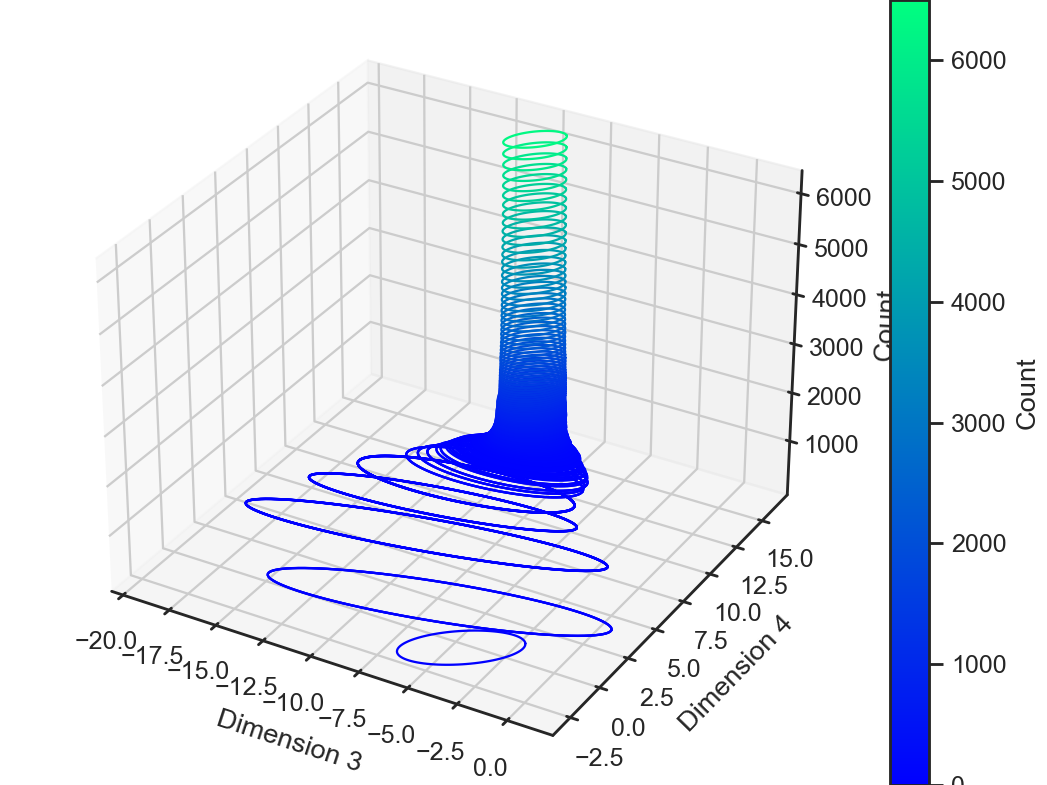

done in 0.280072 seconds.


In [66]:
restart.plot.covmat3.reset()
restart.plot.covmat3()

restart.plot.covmat3.reset()
restart.plot.covmat3(dimensionPair = [2,3])

As seen in the above plots, the proposal adaptations gradually diminish toward the end of the simulation, and the shape of the proposal distribution stabilizes relatively fast.

### Visualizing the covariance and the correlation matrices of the objective function

To construct and visualize the correlation matrix of the sampled points in the chain, we can try, 

ParaDRAM - NOTE: making the heatmap plot... 

<IPython.core.display.Javascript object>


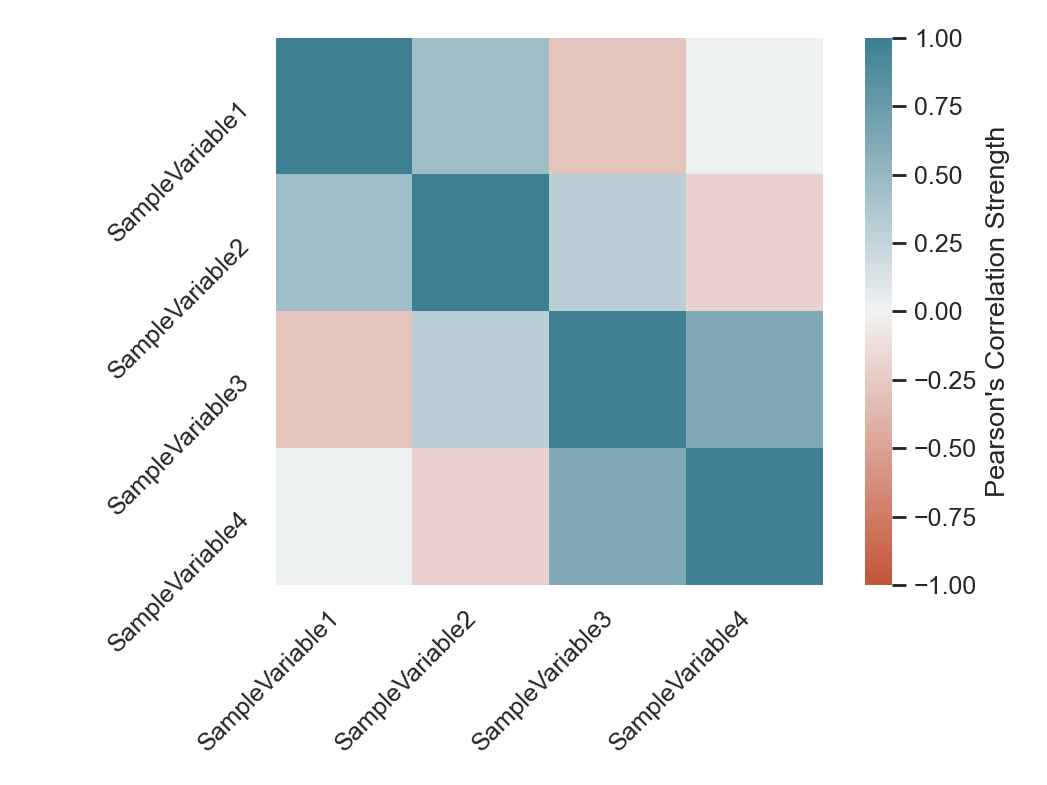

In [67]:
sample.stats.cormat.plot.heatmap()

By default, the covariance and correlation matrices are precmputed at the time of reading the data. In particular, the correlation matrix is computed via the **Pearson's method of computing the correlation**. We can easily recompute the correlation matrix using either **Spearman's** or **Kendal's** rank correlation coefficients, like,  

ParaDRAM - NOTE: adding the correlation graphics tools... 
ParaDRAM - NOTE: creating a heatmap plot object from scratch... done in 0.010442 seconds.
ParaDRAM - NOTE: making the heatmap plot... 

<IPython.core.display.Javascript object>


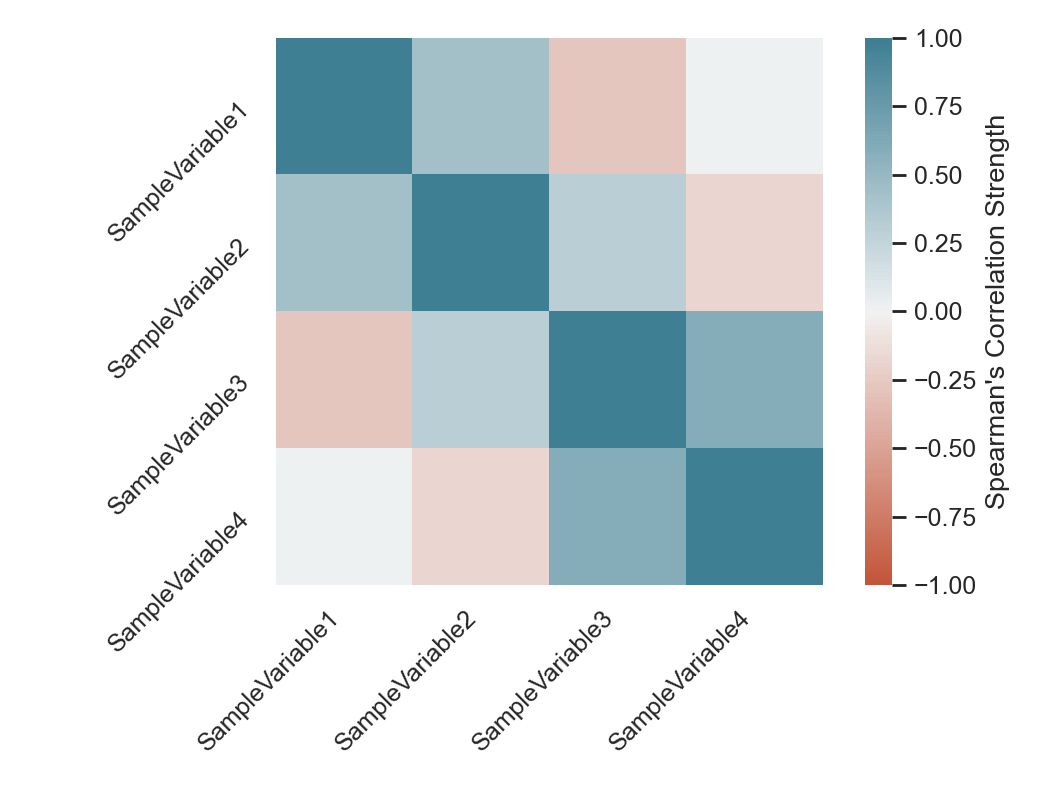

In [68]:
sample.stats.cormat(method="spearman",reself=True).plot.heatmap()

The input argument `reself` requests the function to **re**turn an instance of the **self** object as the function output. To visualize the covariance matrix we can try,  

ParaDRAM - NOTE: making the heatmap plot... 

<IPython.core.display.Javascript object>


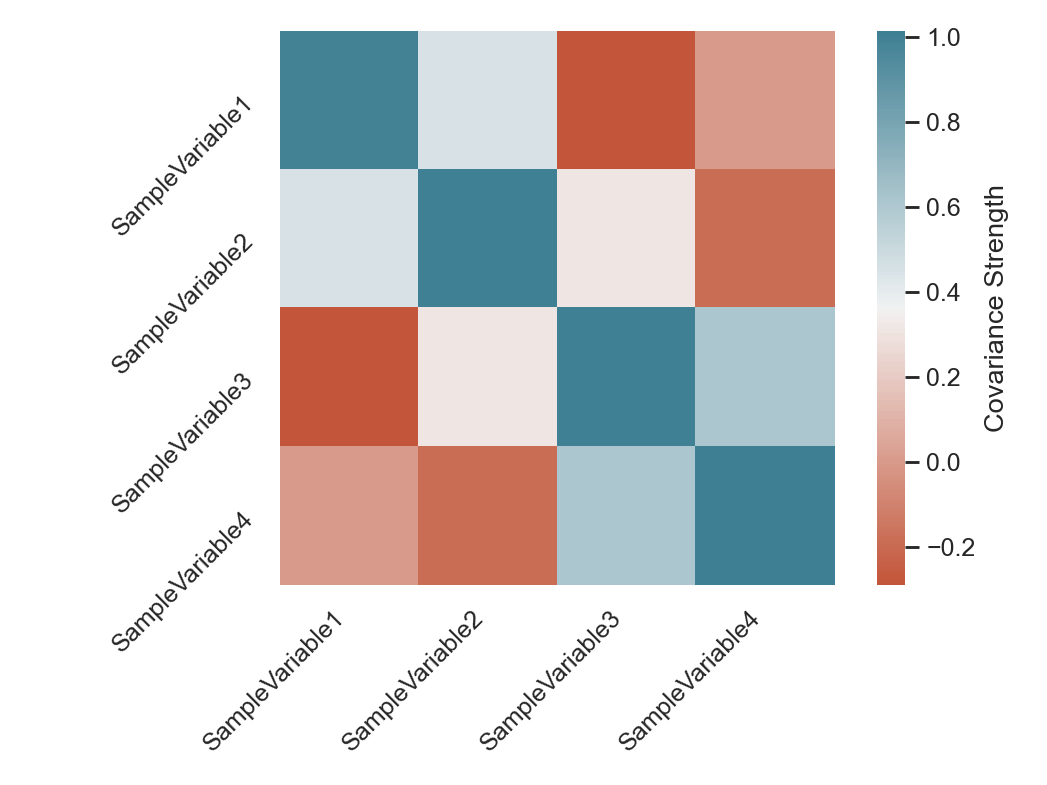

In [69]:
sample.stats.covmat.plot.heatmap()

Note that the same plots can be also made for the compact and verbose (Markov) chains. For brevity, we do not show them here.  

>**There are many more functionalities and features of the ParaMonte library that were neither explored nor mentioned in this example Jupyter notebook. You can explore them by checking the existing components of each attribute of the ParaDRAM sampler class and by visiting the [ParaMonte library's documentation website](http://cdslab.org/paramonte/)**.